
The Hawaii Cesspool Hazard Assessment & Prioritization Tool: 
................................................ Code Notebook ................................................
*August 2021*

**Prepared For:** 
State of Hawai‘i Department of Health Wastewater Branch 
State of Hawai‘i Cesspool Conversion Working Group

**Principal Investigator:** 
- Michael Mezzacapo,University of Hawai‘i Sea Grant College Program, University of Hawai‘i Water Resources Research Center

**Co-Investigator and Primary Software Developer** 
- Christopher Shuler Ph.D., University of Hawai‘i Water Resources Research Center


### Highlights
- Used geospatial analysis to assign and rank multiple risk factors to each osds unit, then integrated them all into a single prioritization score
- Used groundwater models to determine effluent flow paths and link each osds unit to the location along the coastline most affected by its discharge
- In addition to physical drivers of impact, also considered the social and ecological value of impacted areas as a part of the overall ranking


### Methods: Input datasets

#### Physical drivers and risk factors
- These are factors that physically control the transport, attenuation, or otherwise affect the level of impact an OSDS at a given location will have on the environment and water quality

- The impact of an individual OSDS depends on an array of factors regarding the substrate within which it is installed, its location and proximity to sensitive areas, the ultimate discharge point of its effluent and the conservative constituents therein, and the cumulative impacts of other nearby OSDS, which together may more quickly overwhelm the adsorption and contaminant attenuation capacity of the subsurface than an individual system would. 
- We considered all numerically or categorically quantifiable factors relating to variability in OSDS impacts, for which we were able to find statewide datasets, we call these "Risk Factors". 
- While some of the risk factor datasets had missing values we generally only included datasets for which we had a minimum of 90% coverage of the OSDS in the state. 
- For each risk factor we defined a scaler relationship or score between the variable and the spatial location of every individual OSDS unit which was then weighted, and averaged with the scores of all other risk factors to produce a single final prioritization ranking 
- for each individual OSDS in our state-wide inventory, we calculated a numeric value based on the relationship between the location of the OSDS unit and the spatial distribution of the risk factor so that every OSDS unit is assigned a score for every risk factor. 


#### Value- based risk factors
While the physical factors control the level of impact, we have also included value-based factors that quantify the spatial distribution of human and environmental value within the areas calculated to be affected by the discharge of cesspool effluent through the use of groundwater flow modeling.

In [1]:
# load up dependencies and local functions
%run functions.py
from IPython.display import Image

# relative paths
homedir = os.getcwd()
if not os.path.exists(os.path.join(homedir,'tempspace')): os.makedirs(os.path.join(homedir,'tempspace'))  
tempspace = os.path.join(homedir, "tempspace")
intermidiate_DataFramesPath = os.path.join(".", 'Outputs/intermidiate_DataFrames')

pd.set_option('display.max_rows', 10)

In [2]:
# To save time, load dataframes from the pre-run analysis
for i in os.listdir(intermidiate_DataFramesPath):
    name = i.split(".")[0]
    tempframe = pd.read_csv(os.path.join(intermidiate_DataFramesPath, i), index_col=0)
    globals()[str(name)] = tempframe   # This is sly, use globals to define an in-memory variable 
#osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")

## Import OSDS File 
##### This creates a clean OSDS file from which all other cells will pull 
Currently using OSDS_v6 which incorporates 2020 updates from the DoH Wastewater branch IWS Database as well as the 4 counties tax records dwelling databases.  This can easily be substituted as updates to the OSDS inventory are created.

In [5]:
# Read in latest OSDS dataset  has to have an X and Y column in WGS 84

fromshp = os.path.join("..", "Projected_data/Septics_v1_exploded/", 'Exploded_and_Original_data.shp')
OSDS = Format_OSDS_shp(fromshp, cleanitup=True)

# Deal with Dupes
checkdup = OSDS.pivot_table(index=['Uid'], aggfunc='size')
print(f"there are duplicate points at: {checkdup[checkdup != 1]}")
# remove the duplicates (keep first entry of the duplicate row)
OSDS.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
# Reindex or else the future joins will be based on an index with dupes
OSDS.reset_index(drop=True, inplace=True)

# Save csv
OSDS.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS.csv"))

# Convert the now formatted OSDS csv back to a shapefile for the subsequent analyses
csvFilePath = os.path.join(intermidiate_DataFramesPath, "OSDS.csv")
convert_OSDS_csv_to_shp(csvFilePath)

# Define the cleaned up OSDS file all the other cells can use
osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")
print("There are {} (OSDS) in this dataset".format(len(OSDS)))

there are duplicate points at: Series([], dtype: int64)
There are 27943 (OSDS) in this dataset


## Demographic income data
Based on EPA EJ screen application Via https://gaftp.epa.gov/EJSCREEN/2021/
Info is here https://www.epa.gov/ejscreen

In [28]:
# Create the key to join OSDS points to the EJ screen data based on the census block group polygons
In_polygons = os.path.join("..", "Projected_data/Demographics_EPA", 'HI_EJscreen_USPR.shp')
In_points = osds_path
want_cols = ['Uid', 'LOWINCPCT']

LOWINCPCT = Census_data_joining(In_points, In_polygons, want_cols)
LOWINCPCT.to_csv(os.path.join(intermidiate_DataFramesPath, "LOWINCPCT.csv"))


In [30]:
LOWINCPCT

,Uid,LOWINCPCT
0,-155.89725_19.20586,0.288882
1,-155.89724_19.20570,0.288882
2,-155.90023_19.20875,0.288882
3,-155.89958_19.20908,0.288882
4,-155.79086_19.10506,0.805598
...,...,...
27938,-159.47996_21.91216,0.290843
27939,-159.47976_21.91256,0.290843
27940,-159.47976_21.91216,0.290843
27941,-159.48016_21.91256,0.290843


# Cesspool Density  From HCPT report as of Aug 2021
Note this is separate from the septic system density

Average CESSPOOL_Density_perAcre is 0.47465132075977434
Max CESSPOOL_Density_perAcre is 4.757736206050001
Min CESSPOOL_Density_perAcre is 0.0


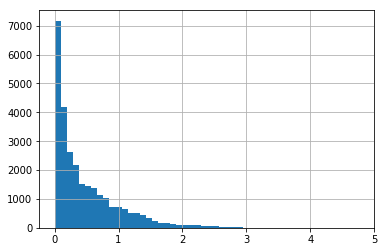

In [34]:
# Convert format to dataframe
new_col_name = "CESSPOOL_Density_perAcre"   # Define new collumn name you want
In_raster = os.path.join("..", "Projected_data/Cesspool_densiy_Aug_2021_HCPT", 'CP_dens.tif')
In_points = osds_path
ExtractValuesToPoints(In_points, In_raster, os.path.join(tempspace, "test_rain_OSDS.shp"))
                         
# read on OSDS data from shapefile into dataframe 
extracted_points_path = os.path.join(tempspace, "test_rain_OSDS.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))
                         
#Select only selected columns
want_cols = ['Uid', 'RASTERVALU']
Extract_frame = Extracted_All[want_cols]
Extract_frame.rename(columns={'RASTERVALU':new_col_name}, inplace=True)     # Rename to col that you want
Extract_frame.loc[Extract_frame[new_col_name] < 0] = np.nan                 # Deal with the -9999 values set to nan

CESSPOOL_DENSITY = Extract_frame.copy()
CESSPOOL_DENSITY.to_csv(os.path.join(intermidiate_DataFramesPath, "CESSPOOL_DENSITY.csv"))

Hist_and_stats_on_DF(CESSPOOL_DENSITY, "CESSPOOL_Density_perAcre")

## Distance to Municipal or domestic wells 

- Previous studies indicate that the distance to a municipal well is an important factor in contamination potential.
- The state regulation is that Zone A for drinking water wells is anything within 50 ft. (Whittier 2010)  

- To determine the locations of pumping wells, we acquired the state well inventory from CWRM. Each well is associated with a use code, which include agricultural, domestic, industrial, irrigation, military, observation uses as well as identifying abandoned and unused wells.  The CWRM dataset was provided directly upon request by Roy Hardy CWRM director (https://dlnr.hawaii.gov/cwrm/).

- Of the 5286 wells within the CWRM dataset 910 were designated as domestic use, and 534 were designated as municipal for a total of 1,444 wells that were considered in this assessment. 

- The distance to domestic wells was assessed separately from the distance to municipal wells, since municipal wells serve proportionally larger numbers of people, and domestic wells are often within close proximity to homes using OSDS'.  Each OSDS unit was assigned the distance between its location and the distance to the nearest domestic well, as well as a separate value for its distance to the nearest municipal well. 

- The weighting numbers will be used to reflect the difference in importance of municipal vs domestic (e.g. municipal wells are 4 times more important than domestic wells) As reflected by split weights of 0.75 and 0.25 respectively in the base scenario


- Note that the scaler regulatory threshold to use for assigning risk-scores for this is the Zone A threshold of 50 ft. We also assessed if OSDS units were within the 2-year and 10-year capture zones (Zones-B and C) of the State SWAP program separately since groundwater flow has the potential to move upgradient contaminants significant distances and this is not captured by a simple distance calculation. (Whittier, 2010) 


Refs: 
Whittier 2010 Groundwater source assessment program for the state of Hawaii, USA: methodology and example application
Robert B. Whittier & Kolja Rotzoll & Sushant Dhal & Aly I. El-Kadi & Chittaranjan Ray & Daniel Chang

Mair, A., & El-Kadi, A. I. (2013). Logistic regression modeling to assess groundwater vulnerability to contamination in Hawaii, USA. Journal of contaminant hydrology, 153, 1-23.

Average dist2_MunWells_m is 2924.5156285397406
Max dist2_MunWells_m is 27607.839908365055
Min dist2_MunWells_m is 45.536563569553365


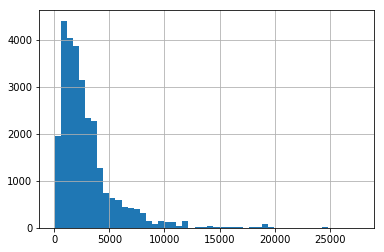

In [72]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_MUN_prj.shp')
new_col_name = "dist2_MunWells_m"
# Run the near analysis 
MUN_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
MUN_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "MUN_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(MUN_WELLS, "dist2_MunWells_m")

Average dist2_DomWells_m is 4979.687983909013
Max dist2_DomWells_m is 36633.998984771286
Min dist2_DomWells_m is 2.3299136430359866


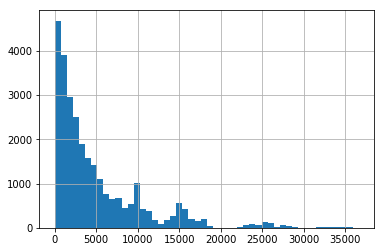

In [73]:
# Generate paramater info about the Domestic wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_DOM_prj.shp')
new_col_name = "dist2_DomWells_m"
# Run the near analysis 
DOM_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
DOM_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "DOM_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(DOM_WELLS, "dist2_DomWells_m")

## Well capture zones


- While the distance from the well as related to the zone threshold was directly assessed we also did an analysis of which osds were located in municipal well capture zones provided by the HI department of health. The composite capture zone dataset as it is publically available and presented in the references below was provided upon request by Bob Whittier at Hi-DOH. 


- A capture zone defines the land area from which infiltrated recharge may ultimately contribute to the groundwater produced at a given well. These Capture zones were calculated through reverse particle tracking of flow in a groundwater model using the MODPATh code.


- Our analysis simply labeled those osds points that fell within a 2-year travel time capture zone and the 10-year travel time capture zone, and ranked these units accordingly by assigning units in the 2 year zone a 100 and those in the 10 year zone a 50 with all other units receiving a zero

### Inside Well capture Zone B

In [74]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneB_Composite.shp')
new_col_name = 'In_WellCZ_B'
In_points = osds_path

WellCZ_B_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_B_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_B_yes.csv"))

print_stats_on_bool_layers(WellCZ_B_yes)

number of affected points = 1035
number of total systems = 27943
percent of systems affected = 0.037039687936155745


### Inside Well capture Zone C

In [75]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneC_Composite.shp')
new_col_name = 'In_WellCZ_C'
In_points = osds_path

WellCZ_C_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_C_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_C_yes.csv"))

print_stats_on_bool_layers(WellCZ_C_yes)

number of affected points = 2315
number of total systems = 27943
percent of systems affected = 0.08284722470744015


## Distance to streams
- Using a basic geographic distance calculation to the nearest point on the streams shapefile from: HAWAII GIS: (https://geoportal.hawaii.gov/datasets/56046b3578064d989ffa485e4ed3dc46/explore?location=20.568900%2C-157.544900%2C8.57, https://geodata.hawaii.gov/arcgis/rest/services/FreshWater/MapServer/1) 


- Distance to stream is an important factor in stream health and contamination potential. 
- Streams layer from gis online is representative of perennial and perennial and non-perennial flowing waters in the state as of 2008. This layer is sometimes referred to as "DAR Streams." Source: USGS Digital Line Graphs, 1983 version; CWRM Hawaii Stream Assessment database, 1993; DLNR Division of Aquatic Resources, 2004, 2008, 2013. (Note - 2013 update from CWRM and DAR included attribute corrections and addition of tributary names, data is current as of March, 2008).


- streams were ultimately joined with wetland features from state gis online dataset


- the distance to any stream or wetland/emergent pond was calculated as a single value to be used in the rankings

Average dist2_Streams_m is 2075.72200632823
Max dist2_Streams_m is 16541.887434644563
Min dist2_Streams_m is 0.15897597709322697


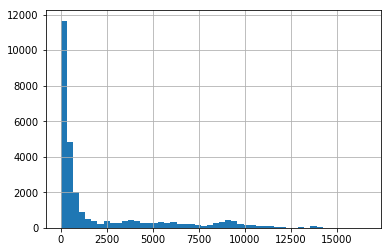

In [76]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Streams", 'Streams_prj.shp')
new_col_name = "dist2_Streams_m"
# Run the near analysis 
STREAMS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
STREAMS.to_csv(os.path.join(intermidiate_DataFramesPath, "STREAMS.csv"))
# plot histogram
Hist_and_stats_on_DF(STREAMS, "dist2_Streams_m")

## Distance to Wetlands
Using a basic geographic distance calculation to the nearest point on the streams shapefile from: HAWAII GIS:(https://geoportal.hawaii.gov/datasets/2250370303ef44c8becf4fbe549e3f43_39, https://www.arcgis.com/sharing/rest/content/items/2250370303ef44c8becf4fbe549e3f43/info/metadata/metadata.xml?format=default&output=html)


- Data is based on Wetlands in the State of Hawaii. Source: USFWS, August, 2019. Description:  This data set represents the extent, approximate location and type of wetlands and deepwater habitats in Hawaii, United States.
- Also includes emergent ponds


- The distance to any stream or wetland/emergent pond was calculated as a single value to be used in the rankings

Average dist2_Wetlands_m is 2271.619012132538
Max dist2_Wetlands_m is 15161.836538981028
Min dist2_Wetlands_m is 0.0


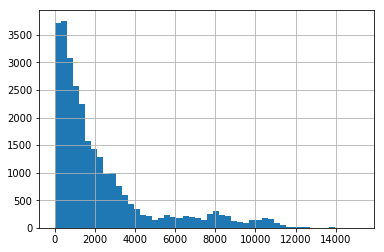

In [77]:
# Generate parameter info about the wetlands
shp_path = os.path.join("..", "Projected_data/Wetlands", 'Wetlands_emergent_ponds.shp')
new_col_name = "dist2_Wetlands_m"
# Run the near analysis 
WETLANDS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
WETLANDS.to_csv(os.path.join(intermidiate_DataFramesPath, "WETLANDS.csv"))
# plot histogram
Hist_and_stats_on_DF(WETLANDS, "dist2_Wetlands_m")

## Distance to the coastline
- Previous studies have determined that the distance between an OSDS unit to its surface water discharge point is a primary factor in determining the composition of the discharged effluent and thus the impact of the system. 


- Here we are using a basic geographic distance calculation to the nearest point on the Hawaii coastline shapefile taken from Hawaii GIS online.  (https://geoportal.hawaii.gov/datasets/045b1d5147634e2380566668e04094c6_3/explore?location=20.556650%2C-157.478000%2C8.60, https://geodata.hawaii.gov/arcgis/rest/services/Terrestrial/MapServer/3)


- Every OSDS unit was assigned a distance to the coast with the max distance, min distance, and histogram below

Average dist2_coast_m is 4910.2359711404615
Max dist2_coast_m is 37772.64238078942
Min dist2_coast_m is 0.105502361019941


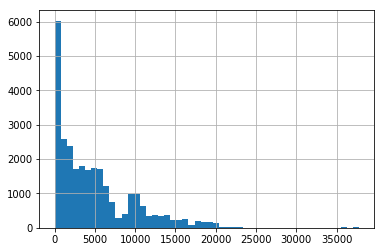

In [78]:
# Generate parameter info about the COASTLINE   looong RUN TIME 
shp_path = os.path.join("..", "Projected_data/Coastline", 'Coastline_line_prj.shp')
new_col_name = "dist2_coast_m"
# Run the near analysis 
COASTLINE = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
COASTLINE.to_csv(os.path.join(intermidiate_DataFramesPath, "COASTLINE.csv"))
# plot histogram
Hist_and_stats_on_DF(COASTLINE, "dist2_coast_m")

## Extracting values from Rainfall raster 
(note need to run this cell before running soils block below) 

- Rainfall directly affects the contamination potential of an OSDS by way of being a proxy for groundwater recharge, whereas:
- a moderate amount of OSDS leachate can significantly increase the groundwater nitrate concentration in low groundwater recharge areas such as the west Hawaii Island.  By contrast, it will take a much greater amount of OSDS leachate to result in even a moderate increase in the groundwater nitrate concentration in high recharge area such as the east side of Hawaii island. 


##### Using rainfall data to fill missing soil flooding values
Addiitionally, rainfall can also act as a proxy for flooding potential, which can cause surface transport of contamination from OSDS, especially cesspools, and cause public health risks. The flood frequency of many locations is already defined by the NRCS soils database, though about fifty (50) percent of the cesspool points were missing flood-frequency data from the NRCS database. Therefore, rainfall amounts were used to determine the likelihood of flooding only in those areas where it was not defined by the NRCS database using the following logic. This logic was established through consultation with DOHWWB and engineering professionals 

- If rainfall is above 135 in and ksat is < 1.1 = Frequent Flooding
- If rainfall is below 15 in and ksat is < 1.1 = Frequent Flooding
- If rainfall is above 135 or ksat is below ksat < 1.1 = Occasional Flooding
- The rainfall data itself was pulled from the Hawai‘i climate atlas as statewide grids of annual rainfall totals. 
(http://rainfall.geography.hawaii.edu/)

To associate the rainfall amounts we extracted the annual rainfall value (in inches) from the rainfall raster to each OSDS point

Average rainfall_in is 70.95345286898241
Max rainfall_in is 235.906265259
Min rainfall_in is 8.42394924164


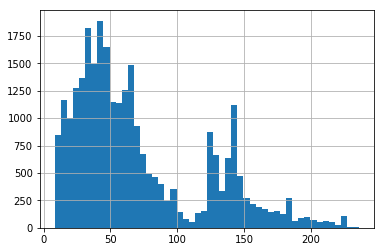

In [79]:
In_raster = os.path.join("..", "Projected_data/Rain", 'Rain_inann.tif')
In_points = osds_path
new_col_name = "rainfall_in"

RAINFALL = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
RAINFALL.to_csv(os.path.join(intermidiate_DataFramesPath, "RAINFALL.csv"))
# plot histogram
Hist_and_stats_on_DF(RAINFALL, "rainfall_in")

## Soils 
- These data were extracted data straight from the NRCS database(https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/geo/?cid=nrcs142p2_053627) , (Ksat data is much better resolution than with the Hawaii soil atlas, which we also looked at https://gis.ctahr.hawaii.edu/SoilAtlas). 


- As noted above: FloodFrequency variable was missing in about half of features so it is filled in with combination of rainfall and k-sat below. 


- Because soil data is polygon data we simply assigned each OSDS point the value of the soil parameter of interest. 
- Parameters included: 
  - **Flood Frequency** - Degree to which the soil is subject to flooding or ponding (nrcs_FloodFreq)
  - **Depth to bedrock** or cemented pan (nrcs_DtoBrock)
  - **Filtering characteristics of the soil** (nrcs_ksat_rep) with ksat >12 ft/day being poor filtering capacity
  - **Rate of water infiltration** through the soil (nrcs_ksat_rep) with ksat < 1.2 ft/day being poor infiltration capacity 
  - **Rate of seepage** out of the bottom layer of the soil (nrcs_ksat_rep) with ksat < 1.1 ft/day being poor seepage
  - **Topographic slope** with slope of more than 15% being problematic for OSDS installation and conversions 
  - **Fraction of rock fragments** in the soil with a % of 3-in rock fragments more than 50% being problematic. 
  - Note that meaning can derived from thresholds in the table in Whittier and El-Kadi (2014) on pg 7-4 (see that table exact limitation numbers) https://health.hawaii.gov/wastewater/files/2015/09/OSDS_NI.pdf
  
  
- These parameters followed the methodology and weighting scheme of Whittier and El-Kadi (2014) (pg 7-4) to create a single soil suitability ranking


- note that the NRCS septic suitability rank was of little value (it was all bad) which is also noted in Whittier and El-Kadi (2014)

In [80]:
# Pull in soils data from NRCS
In_polygons = os.path.join("..", "Projected_data/Soils", 'HIstate_nrcs_join2.shp')
new_col_name = 'Soil_Ksat_2ndry'
In_points = osds_path

# Columns you want from the shapefile (Uid should always  be first one) 
want_cols = ['Uid', 'brockdepmin', 'flodfreqdcd', 'engstafdcd', 'engstafll', 
             'engstafml', 'cokey', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_r', ]  # 'totalsub_r', slopegradw

renames = {'brockdepmi':'nrcs_DtoBrock', 
 'flodfreqdc':'nrcs_FloodFreq',
 'engstafdcd':'nrcs_septic_dominant', 
 'engstafll':'nrcs_septic_least', 
 'engstafml':'nrcs_septic_most', 
 'ksat_h':'nrcs_ksat_hi',  
 'ksat_l':'nrcs_ksat_lo',
 'ksat_r':'nrcs_ksat_rep', 
 'sieveno10_':'nrcs_rockFrag3in'}    # 'slopegradw':'nrcs_slope', 'totalsub_r':'nrcs_subsidence'

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "test_join_pt_2_poly.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

want_cols = ['Uid', 'brockdepmi', 'flodfreqdc', 'engstafdcd', 'engstafll', 
             'engstafml', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_'] # 'slopegradw' , 'totalsub_r'
Extract_frame = Extracted_All[want_cols]

Extract_frame = Extract_frame.replace('NoData', np.nan)  # clean up from arc's trashiness

numcols = ['brockdepmi', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_' ]  #'slopegradw',  'totalsub_r'
Extract_frame[numcols] = Extract_frame[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

Extract_frame.rename(columns=renames, inplace=True)     # Rename to col that you want

SOILS_NRCS = Extract_frame.copy()


#### Filling in missing NRCS flood frequency data with rainfall and ksat
SOILS_NRCS = SOILS_NRCS.merge(RAINFALL, on="Uid", how='left')

# Set frequents 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Frequent"    # "Frequent"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] < 15)]  = "Frequent"    # "Frequent"      

# Set Occasionals 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Occasional"    # "Occasional"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1)]  = "Occasional"    # "Occasional"      

# set rest to none
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull())]  = "None"    # "None"      

del SOILS_NRCS['rainfall_in']

SOILS_NRCS.to_csv(os.path.join(intermidiate_DataFramesPath, "SOILS_NRCS.csv"))

## Slope
- Used slope as a parameter in the soil suitability ranking > 33% is bad for septics according to NRCS. The exact thresholds used were Slope (percent) <8 was no limitation, 8-15% was moderate limitation, and >15% was severe limitation. 


- Data is derived from statewide 10 m DEMs from the Geology coastal group page (http://www.soest.hawaii.edu/coasts/data/hawaii/dem.html) 

# Note using an alternate DEM path at the moment to save space


In [81]:
# Note using an alternate DEM path at the moment to save space
indir = os.path.join("..","..", "Working_copies_REPO", "Projected_data\\DEMs\\Slope_WGS")

Average slope_deg is 4.702100647321115
Max slope_deg is 50.5889511108
Min slope_deg is 0.0


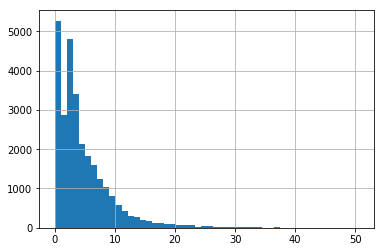

In [82]:
blankframe = pd.DataFrame(columns=["Uid"])

#### indir = os.path.join("..", "Projected_data\\DEMs\\Slope_WGS")  # Using a loop to go over different rasters from different islands
for idx, file in enumerate(os.listdir(indir)):
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "slope_{}".format(idx)       
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['slope_deg'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

SLOPE = blankframe[["Uid", 'slope_deg']]
SLOPE.to_csv(os.path.join(intermidiate_DataFramesPath, "SLOPE.csv"))
# plot histogram
Hist_and_stats_on_DF(SLOPE, "slope_deg")

## Depth to water 

#### Water table Elevations
Did a bit of processing (in tif format in WGS 84) from Bob Whittier's models (obtained through personal communication) 

- The unsaturated zone underlying a cesspool or leachfield is the primary site of subsurface treatment and contaminant attenuation, and the thickness of the unsaturated zone below an OSDS is a major factor in the ability of a given OSDS to treat wastewater.  
- To obtain an estimate of depth to water I first needed to extract ESTIMATED/modeled WT elevations from Bob's groundwater models.  The best citations for these models are:  
 
 
- Whittier, R.B., and El-Kadi, A. I. (2009). Human and environmental risk ranking of onsite sewage disposal systems. Retrieved from: https://health.hawaii.gov/wastewater/files/2015/09/OSDS_OAHU.pdf
- Whittier, R.B., and El-Kadi, A. I. (2014). Human health and environmental risk ranking of onsite sewage disposal systems for the Hawaiian Islands of Kaua'i, Moloka'i, Maui, and Hawai'i. Retrieved from https://health.hawaii.gov/wastewater/files/2015/09/OSDS_NI.pdf
 
 
- Water table depth was calculated in combination with land surface elevation. 
- Unfortunately There is no statewide high-resolution (<1 m dem) lidar data for the state, only for the coastlines. Therefore I downloaded the coastline lidar data from HI GIS online (https://www.arcgis.com/home/webmap/viewer.html?url=https%3A%2F%2Fgeodata.hawaii.gov%2Farcgis%2Frest%2Fservices%2FSoH_Imagery%2FHawaii_DSM%2FImageServer&source=sd) and extracted elevation data to each OSDS point that intersected the available data. 
- Then I filled in missing elevation values with a lower resolution data set (10 m DEMS)  from the UH Coastal Geology group (http://www.soest.hawaii.edu/coasts/data/hawaii/dem.html) 
 
- With the best possible land surface elevation data, and the modeled water table elevations, we subtracted the land elevation from the water table elevation to derive the estimated depth to water. 
- While this is a modeled estimate it is the best available data for a notoriously uncertain parameter.

##### Justification for threshold used:  
From Whittier 2014 pg 4-2 
In this study, the minimum depth to groundwater that allows for sufficient pathogen removal was based on the OSDS design regulations for cesspools. HAR Title 11, Chapter 62 establishes the regulations for wastewater systems and requires that:
• the top of a cesspool inlet pipe must be 1.5 ft below grade;
• there is a minimum of 10 ft between the inlet pipe and the bottom of the tank; and
• a minimum of 3 ft from the bottom of the tank and the highest known level of groundwater.
Based on these values, a minimum depth to the water table should be approximately 15 ft. However, the analysis can be uncertain due to the fact that the elevation of the water table is not static;

Average WT_elev_m is 11.080882295281324
Max WT_elev_m is 829.614318848
Min WT_elev_m is -0.595228612423


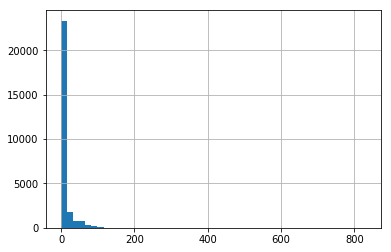

In [83]:
blankframe = pd.DataFrame(columns=["Uid"])
indir = os.path.join("..", "Projected_data\\Water_table\\Tiffs")

for idx, file in enumerate(os.listdir(indir)):     # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "WT_elev_m_{}".format(idx)
         
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['WT_elev_m'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

WT_ELEV = blankframe[["Uid", 'WT_elev_m']]
WT_ELEV.to_csv(os.path.join(intermidiate_DataFramesPath, "WT_ELEV.csv"))
# plot histogram
Hist_and_stats_on_DF(WT_ELEV, "WT_elev_m")

### Land Surface elevations
This relies on first getting data from lidar dem (1m resolution), then if no data get data from the course (10m) resolution ones to create cohesive dataset

##### Very long run time

# Note using an alternate DEM path at the moment to save space

In [84]:
# Note using an alternate DEM path at the moment to save space

indir_crap = os.path.join("..","..", "Working_copies_REPO", "Projected_data\\DEMs\\10mDEM_WGS")
indir_good = os.path.join("..","..", "Working_copies_REPO", "Projected_data\\DEMs\\Lidar_DEM")


working on bidem_wgs.tif
working on KauaiWGS.tif
working on MauiWGS.tif
working on OahuWGS.tif
working on bidem_wgs.tif
working on kauaidem_wgs.tif
working on MauiDEM_WGS.tif
working on oahudem_wgs.tif
Average Elevation_m is 255.72267290072412
Max Elevation_m is 4076.11645508
Min Elevation_m is -24.691329956100002


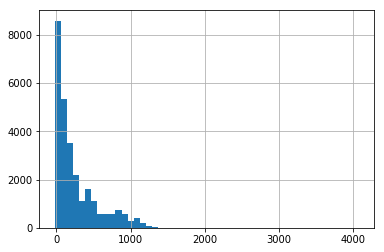

In [85]:
blankframe = pd.DataFrame(columns=["Uid"])
####indir_crap = os.path.join("..", "Projected_data\\DEMs\\10mDEM_WGS")

for idx, file in enumerate(os.listdir(indir_crap)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_crap, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "CrapElev_m_{}".format(idx)
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')
        
blankframe.set_index("Uid", inplace=True)
blankframe['CrapElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_crap = blankframe[["Uid", 'CrapElev']]


####  Now do the same for the lidar dataset  to stitch on ####
blankframe = pd.DataFrame(columns=["Uid"])
###indir_good = os.path.join("..", "Projected_data\\DEMs\\Lidar_DEM")

for idx, file in enumerate(os.listdir(indir_good)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_good, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "LidarElev_m"
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['LidarElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_good = blankframe[["Uid", 'LidarElev']]

# Now Merge Elevations to create a master elevation
Master = OSDS.copy()

Master = Master.merge(ELEV_good, on="Uid", how="left")
Master = Master.merge(ELEV_crap, on="Uid", how="left")

Master['Elevation_m'] = Master['LidarElev']

Master['Elevation_m'] = np.where((Master['LidarElev'].isnull()),   #Identifies the case to apply to 
                           Master['CrapElev'],      #This is the value that is inserted
                           Master['Elevation_m'])      #This is the column that is affected

ELEVATION = Master[["Uid", 'Elevation_m']]
ELEVATION.to_csv(os.path.join(intermidiate_DataFramesPath, "ELEVATION.csv"))

Hist_and_stats_on_DF(ELEVATION, "Elevation_m")

### Calculate Depth to Water for all OSDS points

Average Dep_to_Water_m is 246.73660438080714
Max Dep_to_Water_m is 4052.5594253558997
Min Dep_to_Water_m is 0.0037343502099997927


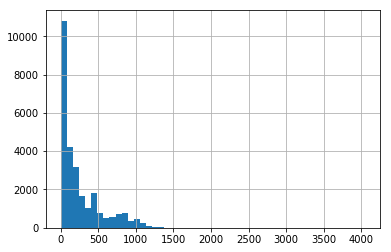

In [86]:
DtoWater = WT_ELEV.merge(ELEVATION, on="Uid", how='outer')                     # merge elevation and WT elevation
DtoWater['Dep_to_Water_m'] = DtoWater['Elevation_m'] - DtoWater['WT_elev_m']   # find the difference 

DtoWater['Dep_to_Water_m'][DtoWater['Dep_to_Water_m'] < 0] = 0.999        # Where it is negative assign value of .999

DTOWATER = DtoWater.copy()
DTOWATER.to_csv(os.path.join(intermidiate_DataFramesPath, "DTOWATER.csv"))

Hist_and_stats_on_DF(DTOWATER, "Dep_to_Water_m")

# Combination, horizontal + Vertical SLR effects
- This is a combination metric, composed of systems that EITHER are inside of the lateral 2d SLR zones as described by the scenarios below OR have a depth to groundwater value that becomes less than 4.4 m (the regulatory standard via 11-62) with a given increase in sea level (assuming purely linear hydrodynamic buoyancy of the freshwater lens under an increase in Base Sea Level) that matches the increase in Sea Level elevation for the future-scenario year.  

## Check if inside SLR zone 2030

- Sea level rise threatens both surface and sub-surface infrastructure. 


- Flooding from below ground can negatively impact the performance of OSDS systems


- Sea level rise data was collected from the HI GIS online https://geoportal.hawaii.gov/datasets/5a4e4fdac72e40bd846c8f3257afd4aa_59?geometry=-163.283%2C20.530%2C-152.829%2C22.320


- OSDS units are assigned highest priority rank if located within 2030 zone with descending ranks if located in 2050 to 2100. 

In [87]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2030 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 4.9]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2030)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2030_prj.shp')
new_col_name = 'InSLR2030'
In_points = osds_path
Hor_SLR_2030 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2030)

SLR_2030_yes = Vertical_SLR_2030.merge(Hor_SLR_2030, on="Uid", how="outer")
SLR_2030_yes = SLR_2030_yes[['Uid', new_col_name]]
SLR_2030_yes[new_col_name] = True   # be sure to set all the rows that are in hor or vert zone to true

SLR_2030_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2030_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2030_yes)

vertical stats
number of affected points = 3173
number of total systems = 27943
percent of systems affected = 0.11355258919944172
Hor stats
number of affected points = 133
number of total systems = 27943
percent of systems affected = 0.00475968936764127
Vert+Hor stats
number of affected points = 3190
number of total systems = 27943
percent of systems affected = 0.11416097054718534


### Check if inside SLR zone 2050 


In [88]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2050 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 5.5]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2050)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2050_prj.shp')
new_col_name = 'InSLR2050'
In_points = osds_path
Hor_SLR_2050 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2050)

SLR_2050_yes = Vertical_SLR_2050.merge(Hor_SLR_2050, on="Uid", how="outer")
SLR_2050_yes = SLR_2050_yes[['Uid', new_col_name]]
SLR_2050_yes[new_col_name] = True  # be sure to set all the rows that are in hor or vert zone to true

SLR_2050_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2050_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2050_yes)

vertical stats
number of affected points = 3298
number of total systems = 27943
percent of systems affected = 0.11802598146226247
Hor stats
number of affected points = 209
number of total systems = 27943
percent of systems affected = 0.007479511863436281
Vert+Hor stats
number of affected points = 3326
number of total systems = 27943
percent of systems affected = 0.11902802132913431


### Check if inside SLR zone 2100

In [89]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2100 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 7.6]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2100)


In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2100_prj.shp')
new_col_name = 'InSLR2100'
In_points = osds_path
Hor_SLR_2100 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2100)

SLR_2100_yes = Vertical_SLR_2100.merge(Hor_SLR_2100, on="Uid", how="outer")
SLR_2100_yes = SLR_2100_yes[['Uid', new_col_name]]
SLR_2100_yes[new_col_name] = True    # be sure to set all the rows that are in hor or vert zone to true

SLR_2100_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2100_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2100_yes)

vertical stats
number of affected points = 3714
number of total systems = 27943
percent of systems affected = 0.1329134309129299
Hor stats
number of affected points = 677
number of total systems = 27943
percent of systems affected = 0.02422789249543714
Vert+Hor stats
number of affected points = 3744
number of total systems = 27943
percent of systems affected = 0.13398704505600686


## Calculate SEPTIC system Density 

Careful parameterization is needed for this, as it can greatly affect the results. 
key questions are how far away from another OSDS does an OSDS need to be for their effects across the landscape to not be cumulative?  This is represented by the parameter:


-  effect_distance

We set this at 360m because personal communication with Joquim at WAI saying that most properties in Hawaii are 1 acre (which is incorrect). Therefore the base resolution of this density analysis is number of OSDS per acre, looking at a 1 acre cell size with a 10 acre search distance around each OSDS

A cell size of 64 meters creates 1 acre cells

- Then the threshold for prioritization was set at one units per 10000 sqft, apparently a thresholds in 11-62?
- This translates to a per acre density of 4.23 units per acre. Note that this was adjusted to 1/4 of this value 1.089 because we are preferring to use a threshold of number of units per acre as it makes more sense in this geography, regarding the note above. 

Average OSDS_Density_perAcre is 0.3129584054610038
Max OSDS_Density_perAcre is 2.2202768325799997
Min OSDS_Density_perAcre is 0.00991195067763


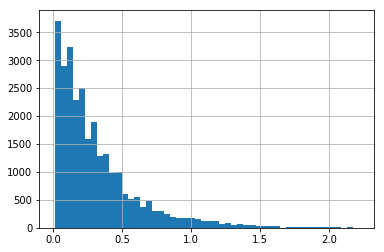

In [90]:
# Project the OSDS dots into UTM4n to get units of meters
input_features = os.path.join("..", "Projected_data/Septics_v1_exploded/", 'Exploded_and_Original_data.shp')
OSDS_utm_path = os.path.join(tempspace, "ClassIV_cespool_UTM4N.shp" )  # replacing "..", "Projected_data/OSDS/UTM", "ClassIV_cespool_UTM4N.shp"
out_coordinate_system = arcpy.SpatialReference('WGS 1984 UTM Zone  4N')
arcpy.Project_management(input_features, OSDS_utm_path, out_coordinate_system)

# Density Parameters
effect_distance_m = 360.5
Density_units = "ACRES"
cellSize = 64     
new_col_name = "OSDS_Density_perAcre"   # Define new collumn name you want

# internal parameters
myNbrCirc = NbrCircle(effect_distance_m, "MAP")
populationField = "NONE"
# Run density algo
outPdens = PointDensity(OSDS_utm_path, populationField, cellSize, myNbrCirc, Density_units)
outPdens.save(os.path.join(tempspace, 'CessPool_density.tif'))

# Convert format to dataframe
In_raster = outPdens
In_points = osds_path
ExtractValuesToPoints(In_points, In_raster, os.path.join(tempspace, "test_rain_OSDS.shp"))

# read on OSDS data from shapefile into dataframe 
extracted_points_path = os.path.join(tempspace, "test_rain_OSDS.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))


#Select only selected columns
want_cols = ['Uid', 'RASTERVALU']
Extract_frame = Extracted_All[want_cols]
Extract_frame.rename(columns={'RASTERVALU':new_col_name}, inplace=True)     # Rename to col that you want
Extract_frame.loc[Extract_frame[new_col_name] < 0] = np.nan                 # Deal with the -9999 values set to nan

OSDS_DENSITY = Extract_frame.copy()
OSDS_DENSITY.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_DENSITY.csv"))

Hist_and_stats_on_DF(OSDS_DENSITY, "OSDS_Density_perAcre")

## Import the Coastal Endpoint ID's from the Bob Model flowpaths
Here referred to as 'Flikr_ID' these are just the 250 m points/cells all along the coastline for all islands with a unique ID that can be used to assign an inland unit to an area of impact along the coast

###### Note to self, the whole Statewide_OSDS_Flikr_Paths_v6.shp needs to be regenerated if using an updated OSDS file. 
otherwise new points will end up with NaN or 0s for Flik ID and will not get assigned coral ranks or userdays

In [91]:
# Read Fliker_ID from the grid cells for each point
In_polygons = os.path.join("..", "Projected_data/ImpactZones_Flik_ID", 'Statewide_GMS_grid_w_Flikr_IDs.shp')
In_points = osds_path

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# Sub in the geographically closest Flikr cell if the OSDS didnt hit a GMS grid cell. and format the Final dataframe
in_features = os.path.join(tempspace, "test_join_pt_2_poly.shp")
Flikr_cells = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", "Flikr_State_250_cells_wMidpoints.shp")
OSDS_FLIK_ID = deal_with_no_FlikrCellsOSDS_pts(in_features, Flikr_cells)

OSDS_FLIK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_FLIK_ID.csv"))

print_costal_endpoint_flik_ID_analytics(OSDS_FLIK_ID, OSDS)

There are 27943 points with Flikr_IDs
There are 27943 OSDS shp points
There are 0 OSDS units in OSDS, that do not have a flikr cell
There are 0 units with a Flikr cell, but are not in the OSDS file


# Value based risk factors
The risk factors presented above are generally based on physical factors that correspond to increase or decrease in the risk of contamination from a given cesspool based on its geographic position or the substrate upon which it is built. 


The factors presented below are calculated based on the groundwater model derived linkage between locations of human or ecological "value". The groundwater model is used to create flow-paths to derive the theoretical point of discharge (along the coast) of every OSDS unit. Ecological value was determined by marine science collaborators and human use value is based upon proxies of visitation and water recreation at coastal locations

## Add visitation level from associated Flikr cell 

 Coastline usage
- Variability in human visitation along the coastline, the primary location of cesspool effluent discharge, was assessed indirectly following the peer-reviewed methodology of (Wood et al. 2013, also see InVEST recreation model documentation https://invest-userguide.readthedocs.io/en/latest/recreation.html), which has been previously proven to be a robust method of assessing user visitation.


- Specifically, photo sharing location data was used as an indirect indicator of human visitation to coastal sites.


-  Flikr an online photo sharing site offers an api service that allows users to query photos based on their geotagged locations. We developed a script (https://github.com/cshuler/Flikr_API_scraping) that assigned points every 250m along the coastline of Oahu, Maui and kauai and every 500 m on Big island, and then queried all the photos that fell within 250 m of each point. This data was then refined using the username of the photo owner and date to calculate the user-days for each point between 2010 and 2020. With a user day being a count of the number of the unique users visiting a given site on a given day, so that the count would not be biased by users who took large amounts of photos at a single location.


- each osds unit was input into a groundwater model (Whittier and El-Kadi, 2009: 2014) and the path of effluent flow down the groundwater table to its discharge point on the coastline was calculated for every single osds in the state. Then the coastline usage data is geographically assigned to each osds unit, thereby allowing every unit to be scored higher or lower priority based on if it affects a coastline area with high or low usage by people


Wood, SA, AD Guerry, JM Silver, M Lacayo. 2013. Using social media to quantify nature-based tourism and recreation. Scientific Reports 3: 2976. (https://www.nature.com/articles/srep02976) 


#### A note on the threshold value used to turn the number # of userdays into a 1-100 score

##### 100 userdays seems to be a reasonable threshold value since it yields about 20 "hotspot" areas on Oahu meaning that if each visitor only went to one hot-spot then we would have about 2000 people uploading photos on a given day which is about 1% of Oahu's average daily visitor count (250K in Feb 2020)

-   GreaterThan  1000 userdays is about 0.5% of total OSDS units
-   GreaterThan  500 userdays is about 1.5% of total OSDS units
-   GreaterThan  185 userdays is about 5% of total OSDS units
-   GreaterThan  100 userdays is about 9% of total OSDS units
-   GreaterThan  90 userdays is about 11% of total OSDS units
-   GreaterThan  50 userdays is about 20% of total OSDS units

(The above was determined using this code)  = 

```user_day_counts = OSDS_Master['UserDays'].value_counts()
sum(list(user_day_counts[user_day_counts >50].index))/len(OSDS_Master)```

Average UserDays is 42.26138925670114
Max UserDays is 1134
Min UserDays is 0


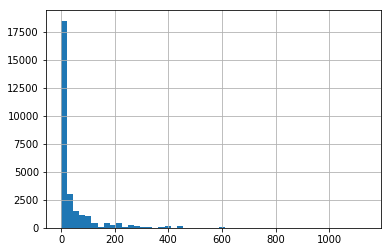

In [92]:
# NOTE this uses OSDS_FLIK_ID (the OSDS Uid to Flik ID key) from above

paths_path = os.path.join("..", "Projected_data/Coast_Usage_Flikr/Processed", 'Statewide_flikr_visitation.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)
carelist = ['Flikr_ID', 'UserDays']  # cut to only wanted cols
Flk_userTemp = tempdf[carelist].copy()

# Do the merge with flikrcells
usedays_merge = OSDS_FLIK_ID.merge(Flk_userTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'UserDays']  # cut to only wanted cols

USERDAYS = usedays_merge[carelist2]
USERDAYS.to_csv(os.path.join(intermidiate_DataFramesPath, "USERDAYS.csv"))

Hist_and_stats_on_DF(USERDAYS, "UserDays")

## Lifeguard towers / swim beaches
- Assumption is that the county governments have determined to spend their limited resources protecting only those beaches with the highest in-water recreational usage. 


- Though there is likely no direct usage data the county agency determinations are the best proxy we are aware of for where there is the greatest value of recreational water use. 


- Therefore any OSDS that drains to a lifeguarded beach meaning standardized 1-1.25 km stretches determined by selecting Flikr cells within 0.5 km of a lifeguard tower, is assigned a 99 score for affects to a recreational swim beach

In [93]:
# input datasets
Flik_dots_path = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", 'State_Gridded_Coast_WGS84_pts.shp')
variable_pts_path = os.path.join("..", "Projected_data/Lifeguard_towers", 'Lifeguard_towers_statewide_final.shp')

# make silly arc layers
arcpy.MakeFeatureLayer_management (Flik_dots_path, "Flik_dots")
arcpy.MakeFeatureLayer_management (variable_pts_path, "variable_pts")

# Select Flik cells(dots) by proximity to LG towers
Selection = arcpy.SelectLayerByLocation_management("Flik_dots", "WITHIN_A_DISTANCE", "variable_pts", "550 meters", "NEW_SELECTION","NOT_INVERT")
arcpy.CopyFeatures_management(Selection, os.path.join(tempspace, "selected_variables.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "selected_variables.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

# Cut out unneded columns and save final dataframe  (Note that the tempframe contains the actual flikr_ID of the guard station for each)
want_cols = ['Uid', 'Swim_beach']
tempframe = Extracted_All.merge(OSDS_FLIK_ID, on="Flikr_ID", how="left")
tempframe["Swim_beach"] = True
SWIM_BEACHES = tempframe[want_cols]
SWIM_BEACHES.to_csv(os.path.join(intermidiate_DataFramesPath, "SWIM_BEACHES.csv"))

# print analysics on how OSDS file from top cell, matches up with results
print("There are {} points draining to swim beaches".format(len(SWIM_BEACHES)))
print("There are {} OSDS shp points".format(len(OSDS)))

There are 3225 points draining to swim beaches
There are 27943 OSDS shp points


## Coastal Ecosystem impact valuations from Marine Biology Group

Resource fish are coral reef fish species that make up a substantial proportion of non-commercial and commercial catch. Therefore this does not represent total fish biomass on the reef, but the subset of fish biomass that directly supports fishing and feeds local communities. Reef fish biomass has been shown to negatively correlate with effluent from OSDS in the Hawaiian Islands (Foo et al., 2021). 
  
The Hawaii Monitoring and Reporting Collaborative (HIMARC) produced predicted maps of standing resource fish biomass and the theoretical recovery potential of resource fish biomass if effluent from on-site sewage disposal systems were eliminated (Donovan et al., 2020). 

A combined ranking of these 2 resource fish biomass datasets were derived for the cesspool conversion prioritization. Each of these datasets were summarized by median biomass within zones spanning 0 - 15 m depth corresponding to 1 km segments of shoreline.

Shore based raster data was mapped onto 250 m grid polygons with 2 added columns ("Coral_rank", and "RFish_rank"). Both have integer values 1-4 where 1 = highest priority and 4 = lowest priority. Data in Pearl Harbor and Hawaii Kai Marina cells to NULL values since we have no reef data there.

Average Coral_rank is 2.8604769152714358
Max Coral_rank is 4.0
Min Coral_rank is 0.0


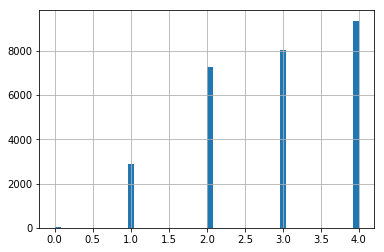

In [94]:
paths_path = os.path.join("..", "Projected_data/Ecosystem", 'CoastGrid_250m_ReefAtts_WGS.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)

# Do a replacement of the Flikr ID to include the island name 
tempdf['Island'] = tempdf['Island'].str.replace('Hawaii','BI')
tempdf["new_flik_ID"] = tempdf["Flikr_ID"]+"_"+tempdf["Island"]
tempdf["Flikr_ID"] = tempdf["new_flik_ID"]

carelist = ['Flikr_ID', 'Coral_rank', "RFish_rank"]  # cut to only wanted cols
Flk_EcoTemp = tempdf[carelist].copy()

# Do the merge with flikrcells for corals
coral_merge = OSDS_FLIK_ID.merge(Flk_EcoTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'Coral_rank']  # cut to only wanted cols

CORAL = coral_merge[carelist2]
CORAL.to_csv(os.path.join(intermidiate_DataFramesPath, "CORAL.csv"))

Hist_and_stats_on_DF(CORAL, "Coral_rank")

Average RFish_rank is 2.614988765673697
Max RFish_rank is 4.0
Min RFish_rank is 0.0


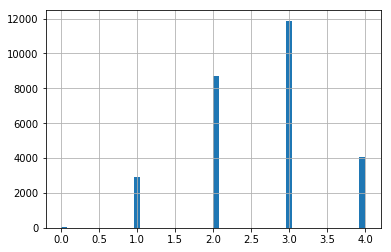

In [95]:
# Do the merge with flikrcells for fish

carelist3 = ['Uid', 'RFish_rank']  # cut to only wanted cols
FISH = coral_merge[carelist3]
FISH.to_csv(os.path.join(intermidiate_DataFramesPath, "FISH.csv"))

Hist_and_stats_on_DF(FISH, "RFish_rank")

# Ocean Circulation proxy
##### Wave Power (in KW/m) Long-term Mean, 2000-2013 – Statewide

Coastal currents and transport are key factors controling mixing and dispersion of pollution. However, modeling these factors is extremely complicated, scale dependent, and temporally  varied. Therefore, accurate statewide data regarding the residence time of coastal waters does not currently exist. There does exist a statewide Long-Term Mean Wave Power dataset (Kappel et al., 2017; Wedding et al., 2018), which the authors determined was the best available proxy for nearshore residence time and coastal circulation at the scale examined in this report. The wave power data used here were obtained from the Ocean Tipping Points Project (https://www.pacioos.hawaii.edu/projects/oceantippingpoints/#data), which consolidates statewide datasets of important coastal parameters. Originally these data were developed by the University of Hawaii at Manoa (UH) School of Ocean and Earth Science and Technology (SOEST) SWAN model (Simulating WAves Nearshore). Hourly 500-m SWAN model runs of wave power were converted to maximum daily wave power from 1979-2013, and The long-term mean wave power was calculated by taking the average of the maximum daily time series of wave power data from 2000-2013 for each 500-m grid cell. 

Here, raster-based wave power values (in KW/m) were mapped to each of the gridded 250/500m coastal cells used above, and for priority scoring we set the primary threshold at the 10% quartile of the wave power dataset (1.59 KW/m) with the idea that this would capture the top 10% of most sheltered areas as the highest priority (score of 100) then priority scores would experience exponential decay as more wave power was experienced by the coastal location of effluent discharge.

Refs:
Kappel, C.V., K.A. Selkoe, and Ocean Tipping Points (OTP). 2017. Wave Power Long-term Mean, 2000-2013 - Hawaii. Distributed by the Pacific Islands Ocean Observing System (PacIOOS). http://pacioos.org/metadata/hi_otp_all_wave_avg.html. Accessed 9-8-21.

Wedding LM, Lecky J, Gove JM, Walecka HR, Donovan MK, et al. (2018) Advancing the integration of spatial data to map human and natural drivers on coral reefs. PLOS ONE 13(3): e0189792. https://doi.org/10.1371/journal.pone.0189792.

Average Wave_pwr is 8.74611974319993
Max Wave_pwr is 30.4539318085
Min Wave_pwr is 0.00545499986038


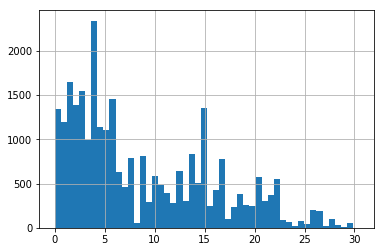

In [96]:
paths_path = os.path.join("..", "Projected_data/Coastal_Circulation", 'Wave_power_KWm_Flikr_pts.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)

carelist = ['Flikr_ID', 'Wave_pwr']  # cut to only wanted cols
Flk_OcircTemp = tempdf[carelist].copy()

# Do the merge with flikrcells for corals
Ocirc_merge = OSDS_FLIK_ID.merge(Flk_OcircTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'Wave_pwr']  # cut to only wanted cols

WAVE_POWER = Ocirc_merge[carelist2]
WAVE_POWER.to_csv(os.path.join(intermidiate_DataFramesPath, "WAVE_POWER.csv"))

Hist_and_stats_on_DF(WAVE_POWER, "Wave_pwr")

# Consolidation into different areas and association of metadata

## Add number of people per household from census tract data
https://geoportal.hawaii.gov/datasets/2010-census-blocks?geometry=-167.932%2C18.755%2C-147.025%2C22.355, https://geoportal.hawaii.gov/datasets/HiStateGIS::2010-census-tracts/explore?location=20.556750%2C-157.478100%2C8.51,  https://geodata.hawaii.gov/arcgis/rest/services/Census/MapServer/21https://geodata.hawaii.gov/arcgis/rest/services/Census/MapServer/21

In [97]:
In_polygons = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Wpopulation.shp')
In_points = osds_path
want_cols = ['Uid', 'PepPerHos']

PPL_PER_HOS = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=False, Level=False)
PPL_PER_HOS.to_csv(os.path.join(intermidiate_DataFramesPath, "PPL_PER_HOS2.csv"))

## Add Census Track IDs

In [98]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Tracts_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'Track_ID']
Level = 'Tracts'

TRACK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
TRACK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "TRACK_ID.csv"))

## Add census block group IDs 


In [99]:
# Create the key to join OSDS points to Census blockgroups
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockGp_ID']
Level = 'Block_Groups'

BLOCKGROUP_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCKGROUP_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCKGROUP_ID.csv"))

## Add census block IDs 

In [100]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockBk_ID']
Level = 'Blocks'

BLOCK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCK_ID.csv"))

## Label if point is within a 2017 cesspool priority zone

In [138]:
In_polygons = os.path.join("..", "Projected_data/Old_2017_priority_areas", 'Old_2017_priority_areas.shp')
new_col_name = 'In_2017_CP_zone'
In_points = osds_path

IN_2017_CP = Find_points_inside_polys(In_points, In_polygons, new_col_name)
IN_2017_CP.to_csv(os.path.join(intermidiate_DataFramesPath, "IN_2017_CP.csv"))

print_stats_on_bool_layers(IN_2017_CP)

number of affected points = 12480
number of total systems = 27943
percent of systems affected = 0.4466234835200229


# Merge together all factors

In [51]:
mergeframes_list = [BLOCK_ID, BLOCKGROUP_ID, TRACK_ID, OSDS_FLIK_ID, USERDAYS, SWIM_BEACHES,
                    COASTLINE, MUN_WELLS, DOM_WELLS, STREAMS, SOILS_NRCS, RAINFALL,  SLOPE, OSDS_DENSITY, WETLANDS,
                    DTOWATER, SLR_2030_yes, SLR_2050_yes, SLR_2100_yes, WellCZ_B_yes, WellCZ_C_yes, 
                    FISH, CORAL, IN_2017_CP, WAVE_POWER, LOWINCPCT, CESSPOOL_DENSITY]  # ELEVATION  # PPL_PER_HOS,
 
# Print out specs on the different lists
for i in mergeframes_list: 
    print(f"{i.columns}, length = {len(i)}")   

# Merge dataframes into master
OSDS_Master = OSDS.copy()
for i in mergeframes_list:
    OSDS_Master = OSDS_Master.merge(i, on="Uid", how="left")

# Some post processing 
OSDS_Master["dist2_Strm_Wtlnd_m"] = OSDS_Master[["dist2_Streams_m", "dist2_Wetlands_m"]].min(axis=1)
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)

OSDS_Master.to_csv(os.path.join(".", "Outputs/OSDS_Dots", 'SEPTICS_MASTER_RiskFactors_v2.csv'), index =False)
print("total length is {}".format(len(OSDS_Master)))

Index(['Uid', 'BlockBk_ID'], dtype='object'), length = 27943
Index(['Uid', 'BlockGp_ID'], dtype='object'), length = 27943
Index(['Uid', 'Track_ID'], dtype='object'), length = 27943
Index(['Uid', 'Flikr_ID', 'Flikr_X', 'Flikr_Y'], dtype='object'), length = 27943
Index(['Uid', 'UserDays'], dtype='object'), length = 27943
Index(['Uid', 'Swim_beach'], dtype='object'), length = 3225
Index(['Uid', 'dist2_coast_m'], dtype='object'), length = 27943
Index(['Uid', 'dist2_MunWells_m'], dtype='object'), length = 27943
Index(['Uid', 'dist2_DomWells_m'], dtype='object'), length = 27943
Index(['Uid', 'dist2_Streams_m'], dtype='object'), length = 27943
Index(['Uid', 'nrcs_DtoBrock', 'nrcs_FloodFreq', 'nrcs_septic_dominant',
       'nrcs_septic_least', 'nrcs_septic_most', 'nrcs_ksat_hi', 'nrcs_ksat_lo',
       'nrcs_ksat_rep', 'nrcs_rockFrag3in'],
      dtype='object'), length = 27943
Index(['Uid', 'rainfall_in'], dtype='object'), length = 27943
Index(['Uid', 'slope_deg'], dtype='object'), length = 278

In [52]:
OSDS_Master.columns

Index(['X', 'Y', 'Island', 'TMK', 'Uid', 'BlockBk_ID', 'BlockGp_ID',
       'Track_ID', 'Flikr_ID', 'Flikr_X', 'Flikr_Y', 'UserDays', 'Swim_beach',
       'dist2_coast_m', 'dist2_MunWells_m', 'dist2_DomWells_m',
       'dist2_Streams_m', 'nrcs_DtoBrock', 'nrcs_FloodFreq',
       'nrcs_septic_dominant', 'nrcs_septic_least', 'nrcs_septic_most',
       'nrcs_ksat_hi', 'nrcs_ksat_lo', 'nrcs_ksat_rep', 'nrcs_rockFrag3in',
       'rainfall_in', 'slope_deg', 'OSDS_Density_perAcre', 'dist2_Wetlands_m',
       'WT_elev_m', 'Elevation_m', 'Dep_to_Water_m', 'InSLR2030', 'InSLR2050',
       'InSLR2100', 'In_WellCZ_B', 'In_WellCZ_C', 'RFish_rank', 'Coral_rank',
       'In_2017_CP_zone', 'Wave_pwr', 'LOWINCPCT', 'CESSPOOL_Density_perAcre',
       'dist2_Strm_Wtlnd_m'],
      dtype='object')

# Column descriptions
- 'X': the x coordinate of the cesspool in WGS84
- 'Y': the y coordinate of the cesspool in WGS84
- 'Island': the island where cesspool is located.  
- 'TMK': the 9-digit tax map key of the parcel where cesspool is located
- 'BlockBk_ID': the census  block ID #
- 'BlockGp_ID': the census  block group ID #
- 'Track_ID': the census track ID #
- 'Flikr_ID': A unique identifier for each coastal grid cell
- 'Flikr_X': the x coordinate of each coastal grid cell 
- 'Flikr_Y': the y coordinate of each coastal grid cell  
- 'UserDays': the average number of user-days recorded by the Flickr photo sharing app for each location
- 'Swim_beach': True is the cesspool drains to a location within 1 km of a coastal lifeguard tower
- 'Uid':  a unique identifier for each point
- 'PepPerHos': join with 2010 census data: the average number of residents per household: via census tracks
- 'dist2_coast_m': distance in meters to the coastline
- 'dist2_MunWells_m': distance to municipal wells in the CWRM database
- 'dist2_DomWells_m': distance to domestic wells in the CWRM database
- 'dist2_Streams_m': distance to streams in the national hydrologic database
- 'nrcs_DtoBrock': depth to bedrock in cm from NRCS soil database (often incomplete)
- 'nrcs_FloodFreq': the soil flooding frequency risk from NRCS soil database (often incomplete)
- 'nrcs_septic_dominant': an NRCS suitability ranking that describes how well suited the given soil type are to handling septic system effluent its actually pretty useless for Hawaii. (dominant is the main score in their ranking strategy)
- 'nrcs_septic_least': same as above but the least suitable rank 
- 'nrcs_septic_most': same as above but the most suitable rank 
- 'nrcs_ksat_hi': High value of the distribution of saturated hydrologic conductivity values for the soil type (in ft/day)
- 'nrcs_ksat_lo': Low value of the distribution of saturated hydrologic conductivity values for the soil type (in ft/day)
- 'nrcs_ksat_rep': Representative value of the distribution of saturated hydrologic conductivity values for the soil type (in ft/day)
- 'nrcs_rockFrag3in': Percentage of the soil composed of rocks >3" in diameter
- 'rainfall_in': the average annual rainfall of the land where OSDS is sited (inches/year )
- 'slope_deg': the slope of the land where OSDS is sited (in degrees)
- 'OSDS_Density_perAcre': the OSDS Density expressed as number of OSDS units/acre
- 'dist2_Wetlands_m': the distance to wetlands in the national hydrologic database
- 'WT_elev_m': The water table elevation where OSDS is sited (in m)
- 'Elevation_m':The ground surface elevation where OSDS is sited (in m)
- 'Dep_to_Water_m': The depth from the ground surface to the water table where OSDS is sited (in m)
- 'InSLR2030': =True if the OSDS unit is sited inside of the projected Sea Level Rise zone for the year 2030 from https://www.pacioos.hawaii.edu/shoreline/slr-hawaii/
- 'InSLR2050': =True if the OSDS unit is sited inside of the projected Sea Level Rise zone for the year 2050
- 'InSLR2100':=True if the OSDS unit is sited inside of the projected Sea Level Rise zone for the year 2100
- 'dist2_Strm_Wtlnd_m': the distance to any stream or wetland in the national hydrologic database (in m)
- "RFish_rank": ranking for fish habitat and recovery potential 
- "Coral_rank": ranking for coral cover and recovery potential 
- "In_2017_CP_zone": binary qualifier to say if the point was in one of the older priority zones from Whittier 2017
- "Wave_pwr": in KW/m,  proxy for ocean circulation, to consider the effect of coastal residence time in ocean waters


# Ranks and weights 

Ingests the OSDS data with risk factors assigned and develops the **risk-factor scores** as well as applying **weights** to each parameter to develop a final **prioritization score.**

In [66]:
# Read in initial thresholds off of csv
thresholds =   pd.read_csv(os.path.join("..", "Projected_data", 'Thresholds_and_Weights_SEP_v1.csv'), index_col=0)
numcols=['W1_base', 'W2_eco', 'W3_anthro', 'T1', 'T2', 'T3']
thresholds[numcols] = thresholds[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

In [68]:
# Load datastets
OSDS_Master = pd.read_csv(os.path.join("Outputs/OSDS_Dots", 'SEPTICS_MASTER_RiskFactors_v2.csv'))
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
baseCols = ['X', 'Y', 'Island', 'TMK', 'Uid', 'In_2017_CP_zone',
             'BlockBk_ID', 'BlockGp_ID', 'Track_ID', 'Flikr_ID']  # 'PepPerHos'
priority_master = OSDS_Master[baseCols].copy()


# Identify variables to consider and rank
Rank_Cols = ['Soil_Suitability_Rank',  'SLR_Rank', 'WELLCZ_Rank', 'dist2_coast_m_Rank', 
             'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank', 'dist2_MunWells_m_Rank', 
             'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank', 'OSDS_Density_perAcre_Rank',
             'Swim_beach_Rank', 'UserDays_Rank', 'Fish_Rank', 'Coral_Rank', 'Wave_pwr_Rank', 
             'CESSPOOL_Density_perAcre_Rank']  # , 'PepPerHos_Rank'

In [69]:
# Deal with some naming issues
OSDS_Master['nrcs_ksat_rep_slowwater'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_filtering'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_bottomseepage'] = OSDS_Master['nrcs_ksat_rep'].copy()

## Create a consolidated soil suitability rank that takes into consideration: 
- Depth to Bedrock or Cemented Pan  100%       
- Flooding or Ponding               100%  
- Filtering Capacity (ft/d)         100% 
- Slow Water Movement (ft/d)        100% 
- Seepage From Bottom Layer (ft/d)  33%
- Slope (percent)                   33% 
- Percent Rock Fragments > 3”       33%   

In [70]:
# create a Soil suitability rank, with all 7 parameters equally weighted  ( high values = LEAST SUITABLE)

plist =  ['nrcs_ksat_rep_slowwater', 'nrcs_DtoBrock', 'nrcs_ksat_rep_filtering', 
          'nrcs_ksat_rep_bottomseepage', 'slope_deg', 'nrcs_rockFrag3in']

# Prioritize thresholded ones
framedic_Soil_temp = {}
for idx, col in enumerate(plist):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_Soil_temp["Rank_{}".format(col)] = cut_by_three_numeric_thresholds(OSDS_Master, col, Ty, T1, T2, T3)
    
    # Soil Type Flood Frequency 
FLOOD_FREQ = OSDS_Master[["Uid", 'nrcs_FloodFreq']].copy()
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "None", 'nrcs_FloodFreq_Rank'] = "P4"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Rare", 'nrcs_FloodFreq_Rank'] = "P3"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Occasional", 'nrcs_FloodFreq_Rank'] = "P2"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Frequent", 'nrcs_FloodFreq_Rank'] = "P1"
framedic_Soil_temp["Rank_nrcs_FloodFreq"] = FLOOD_FREQ[["Uid", 'nrcs_FloodFreq_Rank']]

# Change out the P values with numeric values
for key in framedic_Soil_temp.keys():
    framedic_Soil_temp[key].replace(to_replace = "P1", value = 99, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P2", value = 66, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P3", value = 33, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P4", value = 1, inplace = True)
    
# Merge dataframes into master
SOIL_MASTER = priority_master.copy()
for i in framedic_Soil_temp.keys():
    SOIL_MASTER = SOIL_MASTER.merge(framedic_Soil_temp[i], on="Uid", how="left")   
    
# This contains the internal weightings for the soil suitability rank
Prioritization_vars_dic = {
    'nrcs_ksat_rep_slowwater_Rank':1,
    'nrcs_ksat_rep_bottomseepage_Rank':0.33,
    'nrcs_ksat_rep_filtering_Rank':1,
    'nrcs_DtoBrock_Rank':1,
    'nrcs_FloodFreq_Rank':1,
    'slope_deg_Rank':0.33,
    'nrcs_rockFrag3in_Rank':0.33  }

# Run the interlal weightings for the suitibility rank
for var in Prioritization_vars_dic.keys():
    SOIL_MASTER[var] = SOIL_MASTER[var]*Prioritization_vars_dic[var]

SOIL_MASTER['Soil_Suitability_Rank'] = SOIL_MASTER[list(Prioritization_vars_dic.keys())].mean(axis=1)
# Save the consolidated soil rank by itself
SOIL_MASTER = SOIL_MASTER[['Uid', 'Soil_Suitability_Rank']]

# Discussion about ranking methods

- We wanted to incorporate thresholds because they are often the only published guidance on the subject. 
- However these thresholds are often arbitrary, and using a single inside or outside type breakpoint does not represent reality

- Whittier and El-Kadi (2014) used a simplified scoring system based on presence or absence of specific risk factors (and their associated thresholds) underlying each factor. While this scoring paradigm is useful and has precedence, it 1) is highly dependent on value-based judgements, and 2) because only a limited number of rankings were possible (0 to 7) and a limited number of factors were included, it biased the prioritization score towards less important factors, since more important factors could not be weighted more heavily. We build upon this method by creating a data driven framework to allow for customization and tuning of the scores as well as providing an opportunity to weigh factors independently to assess the effects of different end goal values on the final prioritization.


There are a couple of schools of thought about assigning risk. The regulatory model uses a threshold-based system, essentially as a step function to either determine if a system is compliant or not compliant with a particular regulation or setback distance e.g. 50 ft setback from the coast. However, the regulatory thresholds are typically surpassed by only a small percentage of all OSDS systems, which limits the utility of such a step function in the context of this exercise. A more physically based approach that considers the mechanics of groundwater flow including the processes of dispersion, diffusion, and first-order decay, can be used to treat impact as if it were analogous to concentration of a dissolved contaminant in the groundwater. However, to apply this approach numerous site specific parameters are needed, including seepage velocity, porosity, hydraulic conductivity, and water table gradient. These parameters are neither well constrained in the Hawaiian islands, nor are they homogeneous across any flowpath traversing the island's subsurface. Because of the limitations that preclude modeling these processes directly for each OSDS, and to incorporate the prior considerations of many scholars, managers, and scientists who have developed various prior regulatory thresholds, we have opted to apply a hybrid approach of assigning risk scores that considers both regulatory setbacks, and also applies a 'decay with distance' function that reflects a simplified scaled-decay function based on the behavior of the one-dimensional convective-dispersive solute transport equation (Van Genuchten, 1982). One complication is that this function is scale dependent, being reliant on the aforementioned hydrologic parameters, three of which (seepage velocity, hydraulic conductivity, and water table gradient) all incorporate units of length. To generalize the solution we instead scale the decay upon available values of regulatory thresholds themselves for each numeric risk factor by assigning a maximum risk (score of 100) to points above the threshold, and then exponentially reduce the risk score as points get farther away from the threshold value. This decay function follows a simplified version of the solution to the 1-d solute transport equation by replacing the scale dependent parameters with a single parameter that uses the median value of each risk-factor distribution to control the rate of decay with distance from the feature of interest. This method ensures that OSDS units that are just past the threshold values are still considered to be higher priority than OSDS units that are much farther away from the threshold.

    Van Genuchten, M. T. (1982). Analytical solutions of the one-dimensional convective-dispersive solute transport equation (No. 1661). US Department of Agriculture, Agricultural Research Service.

## Prioritization Function: Threshold then 1d-convective dispersive decay: 100 pt scale

In [71]:
# Threshold then exponential decay
def threshold_then_decay(OSDS_df, col_name, T1, ascending):
    # reminder, 100 is bad/more impactful, 0 is good/least impactful
    
    return_frame = OSDS_df[["Uid", col_name]].copy()
    
    scaler = return_frame[col_name].median()*.1   # this scale factor controls the shape of the exponential decay and essentially revises the value at which scores transition from high (90s and above) to lower
    #print("for {} scaler is {}".format(col_name, scaler))
    
    if ascending == True:
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100*((T1+scaler)/(return_frame[col_name]+scaler))
       
        
    if ascending == False:
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100*(return_frame[col_name]+scaler)/(T1+scaler)

    return_frame = return_frame[["Uid",'{}_Rank'.format(col_name)]]
    
    return return_frame 


# a 0 to 100 scaler function
def MY_minmaxscaler_dfCol(col, reverse=False):   
    # Reverse True indicates that bigger data values   (e.g dist to coast) get smaller ranks meaning less impact 
    # Reverse False indicates that smaller data values (e.g OSDS_density)  get smaller ranks meaning less impact  
    
    mx = col.max()
    mn = col.min()   
    if reverse==False:
        scaled_series = 100*(col-mn)/(mx-mn)       
    if reverse==True:
        scaled_series = 100*(col-mx)/(mn-mx)
    
    return scaled_series

In [72]:
framedic_decay = {}

# Loop over the non-soil parameters and add their ranks to the dic
plist_ascending =  ['dist2_coast_m', 'dist2_Strm_Wtlnd_m', 'dist2_MunWells_m',
                    'dist2_DomWells_m', 'Dep_to_Water_m', 'rainfall_in', 'Wave_pwr'] 
plist_decending =  ['OSDS_Density_perAcre', 'UserDays', 'CESSPOOL_Density_perAcre']

for idx, col in enumerate(plist_ascending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=True)

for idx, col in enumerate(plist_decending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=False) 

In [73]:
# Add in the non-loopable (thresholded) parameters to the framedic

# Add the soil ranking
framedic_decay['SOIL_MASTER'] = SOIL_MASTER

# Sea Level Rise  'InSLR2030', 'InSLR2050',  'InSLR2100'
SLR = OSDS_Master[["Uid", 'InSLR2030', 'InSLR2050',  'InSLR2100']].copy()
SLR['SLR_Rank'] = 0
SLR.loc[SLR['InSLR2100'] == True, 'SLR_Rank'] = 33
SLR.loc[SLR['InSLR2050'] == True, 'SLR_Rank'] = 66
SLR.loc[SLR['InSLR2030'] == True, 'SLR_Rank'] = 100
framedic_decay["Rank_SLR"] = SLR[["Uid", 'SLR_Rank']]

# Well Capture Zones
WELLCZs = OSDS_Master[["Uid", 'In_WellCZ_B', 'In_WellCZ_C']].copy()
WELLCZs['WELLCZ_Rank'] = 0
WELLCZs.loc[WELLCZs['In_WellCZ_C'] == True, 'WELLCZ_Rank'] = 50
WELLCZs.loc[WELLCZs['In_WellCZ_B'] == True, 'WELLCZ_Rank'] = 100
framedic_decay["Rank_WELLCZ"] = WELLCZs[["Uid", 'WELLCZ_Rank']]

# Swim beaches
SWIMBEACH = OSDS_Master[["Uid", 'Swim_beach']].copy()
SWIMBEACH['Swim_beach_Rank'] = 0
SWIMBEACH.loc[SWIMBEACH['Swim_beach'] == True, 'Swim_beach_Rank'] = 100
framedic_decay["Rank_Swim_beach"] = SWIMBEACH[["Uid", 'Swim_beach_Rank']]

# Fish   # Note that the original col was named RFish_rank with a small r the Fish_Rank with big R is the 0-100 score
FISHY = OSDS_Master[["Uid", 'RFish_rank']].copy()
FISHY['Fish_Rank'] = 0
FISHY.loc[FISHY['RFish_rank'] == 1, 'Fish_Rank'] = 100
FISHY.loc[FISHY['RFish_rank'] == 2, 'Fish_Rank'] = 66
FISHY.loc[FISHY['RFish_rank'] == 3, 'Fish_Rank'] = 33
FISHY.loc[FISHY['RFish_rank'] == 4, 'Fish_Rank'] = 0
framedic_decay["Rank_Fish"] = FISHY[["Uid", 'Fish_Rank']]

# Coral    Note that the original col was named Coral_rank with a small r the Coral_Rank with big R is the 0-100 score
CORALY = OSDS_Master[["Uid", 'Coral_rank']].copy()
CORALY['Coral_Rank'] = 0
CORALY.loc[CORALY['Coral_rank'] == 1, 'Coral_Rank'] = 100
CORALY.loc[CORALY['Coral_rank'] == 2, 'Coral_Rank'] = 66
CORALY.loc[CORALY['Coral_rank'] == 3, 'Coral_Rank'] = 33
CORALY.loc[CORALY['Coral_rank'] == 4, 'Coral_Rank'] = 0
framedic_decay["Rank_Coral"] = CORALY[["Uid", 'Coral_Rank']]


# Add number of people per household
####Pep_hos = OSDS_Master[["Uid", 'PepPerHos']].copy()
####Pep_hos['PepPerHos_Rank'] = MY_minmaxscaler_dfCol(OSDS_Master['PepPerHos'], reverse=False)
####framedic_decay["Rank_PepPerHos"] = Pep_hos[["Uid", 'PepPerHos_Rank']]

27943


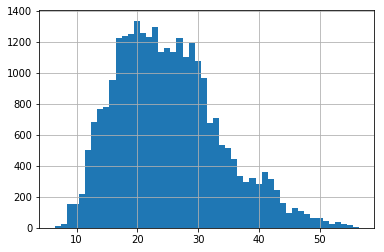

In [75]:
# Merge dataframes into master
DECAY_PRIORITY_MASTER = priority_master.copy()
for i in framedic_decay.keys():
    DECAY_PRIORITY_MASTER = DECAY_PRIORITY_MASTER.merge(framedic_decay[i], on="Uid", how="left")

# Create the single mean rank
DECAY_PRIORITY_MASTER['Priority_mean'] = DECAY_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

print(len(DECAY_PRIORITY_MASTER))
DECAY_PRIORITY_MASTER['Priority_mean'].hist(bins=50)

#Print out a copy to use in the sensitivity testing notebook
DECAY_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "DECAY_PRIORITY_MASTER.csv"), index=False)

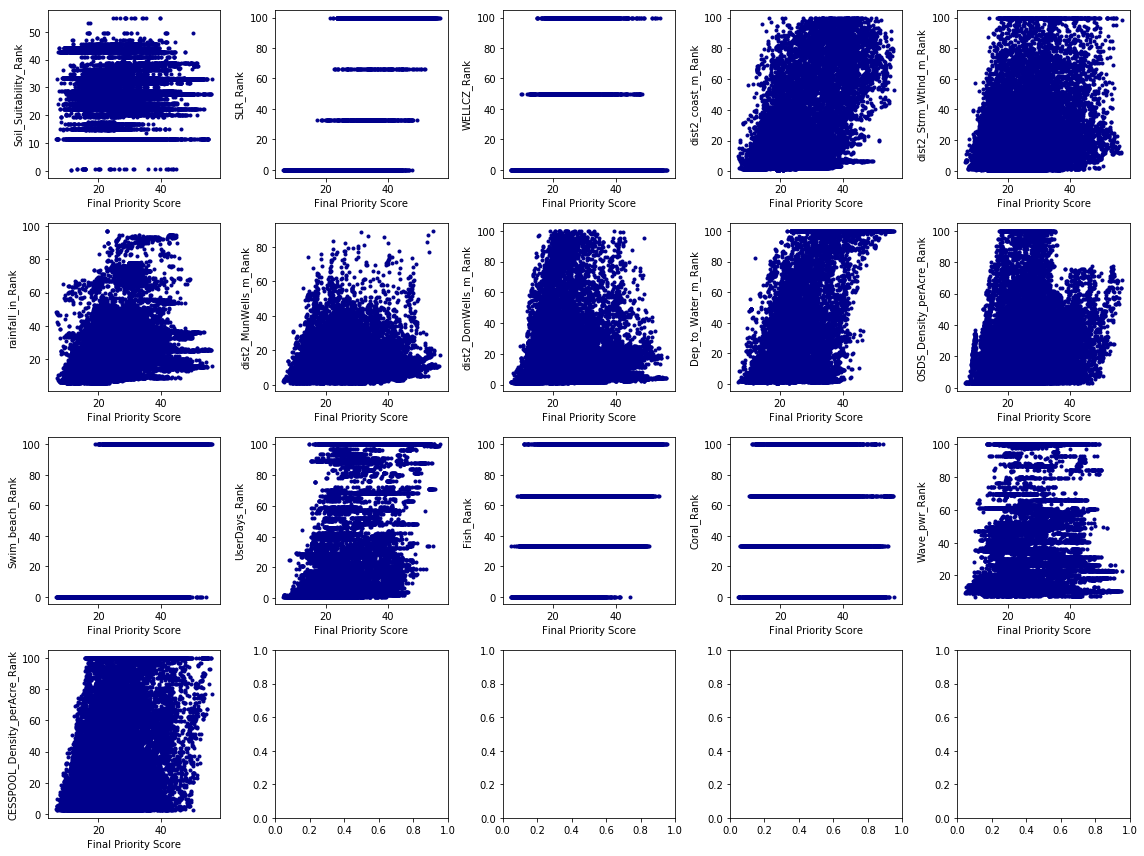

In [81]:
# Plot the comparison between individual risk factor scores and the final priority score.  
fig, ax = plt.subplots(4,5, figsize=(16, 12))
for idx, col in enumerate(Rank_Cols):
    ax = plt.subplot(4,5,idx+1)
    x = DECAY_PRIORITY_MASTER['Priority_mean']
    y = DECAY_PRIORITY_MASTER[col]
    plt.scatter(x, y, marker=".", color='darkblue')
    plt.ylabel(col); plt.xlabel('Final Priority Score')
    plt.tight_layout()

# Base Scenario

This framework provides the ability to weigh the influence of each risk factor on the final priority score for each unit. Weighting can be done by multiplying the individual parameter score by a weight value, for example a weight value of two (2) can be used if it is desired for a parameter to be twice as important as those with a weighting value of one (1).

Because it is beyond the scope of this project to make quantitative judgements on the value of impacted ecosystems or populations, the Base Scenario applies the 'default' weight of one (1) to each factor included in the prioritization. This acknowledges that each factor is important, but also is clearly a limitation of the approach in that the degree of importance is probably not equal. The decision to leave out weighting of the factors was made with the intention that this prioritization scheme can and should be updated in the future after convening a panel of experts and stakeholders to discuss the social, technical, and value-based aspects of each factor in order to develop an updated weighting scheme, that in turn can be immediately used within this framework to develop an updated prioritization list. That, however, will be a project in its own right.

Note that the only change performed in this cell from the DECAY_PRIORITY_MASTER calculation right now is assigning the weight of .25 to dom wells, and 0.75 to muni wells in order to make them add up to an overall priority of 1

Note, at one point I was scaling the final priority score into 0-100 space for comparisons between scenarios, but this might not be the best idea. used this syntax BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = MY_minmaxscaler_dfCol(BASE_PRIORITY_MASTER['Weighted_Priority_mean'], reverse=False)

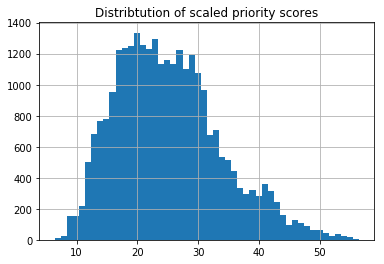

In [82]:
BASE_PRIORITY_MASTER = DECAY_PRIORITY_MASTER[baseCols].copy()  # Create base for weighting

# Apply weights to each column
for i in Rank_Cols: 
    col = i.replace("_Rank", "")
    weight = thresholds.loc[col]['W1_base']
    
    # Average the two methods and apply weights
    BASE_PRIORITY_MASTER[i] = DECAY_PRIORITY_MASTER[i]*weight
    
    
BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = BASE_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

# prepare the final to be able to determine if more than 50% of the OSDS units are in a Priority zone (average wont count NaN as 0)
BASE_PRIORITY_MASTER['In_2017_CP_zone'].fillna(False, inplace=True)

# Plots 
BASE_PRIORITY_MASTER['Weighted_Priority_mean'].hist(bins=50)
plt.title('Distribtution of scaled priority scores')

BASE_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "BASE_PRIORITY_MASTER.csv"))

## Consolidate Individual OSDS units into Census Polygon groups:
Different resolutions include: - 2010 Census Tracks, - 2010 Census Block Groups, - 2010 Census Blocks

This assigns the average final priority score of the OSDS units that fall within each geographic polygon to the census unit. A parameter to exclude units that do not contain some minimum number of OSDS is available to avoid biasing the prioritization by areas with an insignificant number of OSDS units


#####  Also delineate Priority categories (High, Med Low) Categories are defined primarily by our ranking¶
- with top 10% highest priority scores as High
- top 11% to 50% as Medium
- Bottom 50% as low 

Then the zones in the 2017 priority zones are delineated by a +

Therefore the final Priority categories are defined for each census zone (tracks, blocks, block groups) where the average priority score of all of the OSDS units falling into the given geographic area (of those areas where the number of OSDS units is greater than the cutoff (25 for tracks, 20 for block groups, 15 for blocks) is:

- **High Priority +**:  the top 10% of the zone-averaged priority scores that also have 50% or more of their OSDS units falling within a 2017 priority zone. 
- **High Priority**:  the top 10% of the zone-averaged priority scores that do not have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Medium Priority +**:  the middle 40% (50%-10%) of the zone-averaged priority scores that also have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Medium Priority**:  the middle 40% (50%-10%) of the zone-averaged priority scores that do not have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Low Priority +**:  the bottom 50% of the zone-averaged priority scores that do have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Low Priority:**  the bottom 50% of the zone-averaged priority scores that do have 50% or more of their OSDS units falling within a 2017 priority zone.

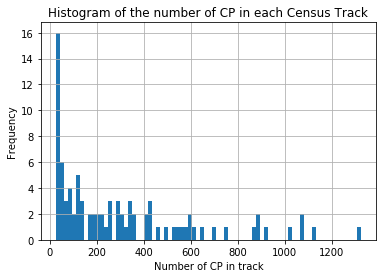

In [84]:
# Consolidate the many CP units into tracks, remembering that the 
UnitCol = 'Track_ID'
Tracks_priority_frame_base = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=25)
Tracks_priority_frame_base['OSDS_count'].hist(bins=len(Tracks_priority_frame_base['OSDS_count'].unique()))
plt.title("Histogram of the number of CP in each Census Track"); plt.xlabel("Number of CP in track"); plt.ylabel("Frequency")

In [85]:
Tracks_priority_frame_base.columns

Index(['Track_ID', 'BlockBk_ID', 'BlockGp_ID', 'CESSPOOL_Density_perAcre_Rank',
       'Coral_Rank', 'Dep_to_Water_m_Rank', 'Fish_Rank', 'In_2017_CP_zone',
       'OSDS_Density_perAcre_Rank', 'SLR_Rank', 'Soil_Suitability_Rank',
       'Swim_beach_Rank', 'TMK', 'UserDays_Rank', 'WELLCZ_Rank',
       'Wave_pwr_Rank', 'Weighted_Priority_mean', 'X', 'Y',
       'dist2_DomWells_m_Rank', 'dist2_MunWells_m_Rank',
       'dist2_Strm_Wtlnd_m_Rank', 'dist2_coast_m_Rank', 'rainfall_in_Rank',
       'OSDS_count', 'Final_Prioity_Score', 'Final_Prioity_Rank',
       '50pct_In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank'],
      dtype='object')

In [86]:
# Cut columns to desired ones 
WantCols = ['Track_ID', 'Final_Prioity_Score','Soil_Suitability_Rank', 'SLR_Rank', 'WELLCZ_Rank',
       'dist2_coast_m_Rank', 'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank',
       'dist2_MunWells_m_Rank', 'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank',
       'OSDS_Density_perAcre_Rank', 'Swim_beach_Rank', 'UserDays_Rank', "Fish_Rank", "Coral_Rank", 'Wave_pwr_Rank',
       'OSDS_count']   # will delete OSDS count once is in name col   #  'PepPerHos_Rank',
 
compare_priority_score_Track = Tracks_priority_frame_base[WantCols]
compare_priority_score_Track = compare_priority_score_Track.sort_values("Final_Prioity_Score", ascending=False)


# Get and set track names to the index
trackpath = os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Tracts_Meta_w2017.shp') 
Track_meta = get_track_names(trackpath, "Track_ID")  # in the functions file
compare_priority_score_Track = compare_priority_score_Track.merge(Track_meta, on='Track_ID', how='left')
# Add on the # of CPs to the index 
compare_priority_score_Track['Name_ID'] = compare_priority_score_Track['Name_ID']+": CPs="+compare_priority_score_Track['OSDS_count'].astype(str)
compare_priority_score_Track = compare_priority_score_Track.set_index('Name_ID')                                  # Convert to pandas bliss
del compare_priority_score_Track['Track_ID'];  del compare_priority_score_Track['OSDS_count']

# make 
renamas = {'Final_Prioity_Score':'Final Prioity Score', 
            'Soil_Suitability_Rank':'Soil Suitability',
            'SLR_Rank':'Sea Level Rise',
            'WELLCZ_Rank':'Well Capture Zones',
            'dist2_coast_m_Rank':'Dist. to Coast',
            'dist2_Strm_Wtlnd_m_Rank':'Dist. to Strms/Wtlnds',
            'rainfall_in_Rank':'Rainfall',
            'dist2_MunWells_m_Rank':'Dist. to Muni. Wells',
            'dist2_DomWells_m_Rank':'Dist. to Dom. Wells',
            'Dep_to_Water_m_Rank':'Depth to GW',
            'OSDS_Density_perAcre_Rank':'OSDS Density',
            'Swim_beach_Rank':'Swim Beaches',
            'UserDays_Rank':'Coastline Usage',
            'Fish_Rank':'Reef Fishery Priority',
            'Coral_Rank':'Coral Reef Priority', 
            'Wave_pwr_Rank': 'Wave Power'}    # , 'PepPerHos_Rank':'People per House'}

compare_priority_score_Track.rename(columns=renamas, inplace=True)     # Rename to col that you want

The island of Statewide contains 27221 cesspools and has a total of 103 census tracts although only 88 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 25% or 22 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 25% or 22 of them were categorized as medium (2) priority and 50% or 44 of them were categorized as low (3) priority. The total number of cesspools on Statewide catergorized as high (1) priority was 5015, with 6544 and 15662 as medium (2) and low (3) priority, respectivly.


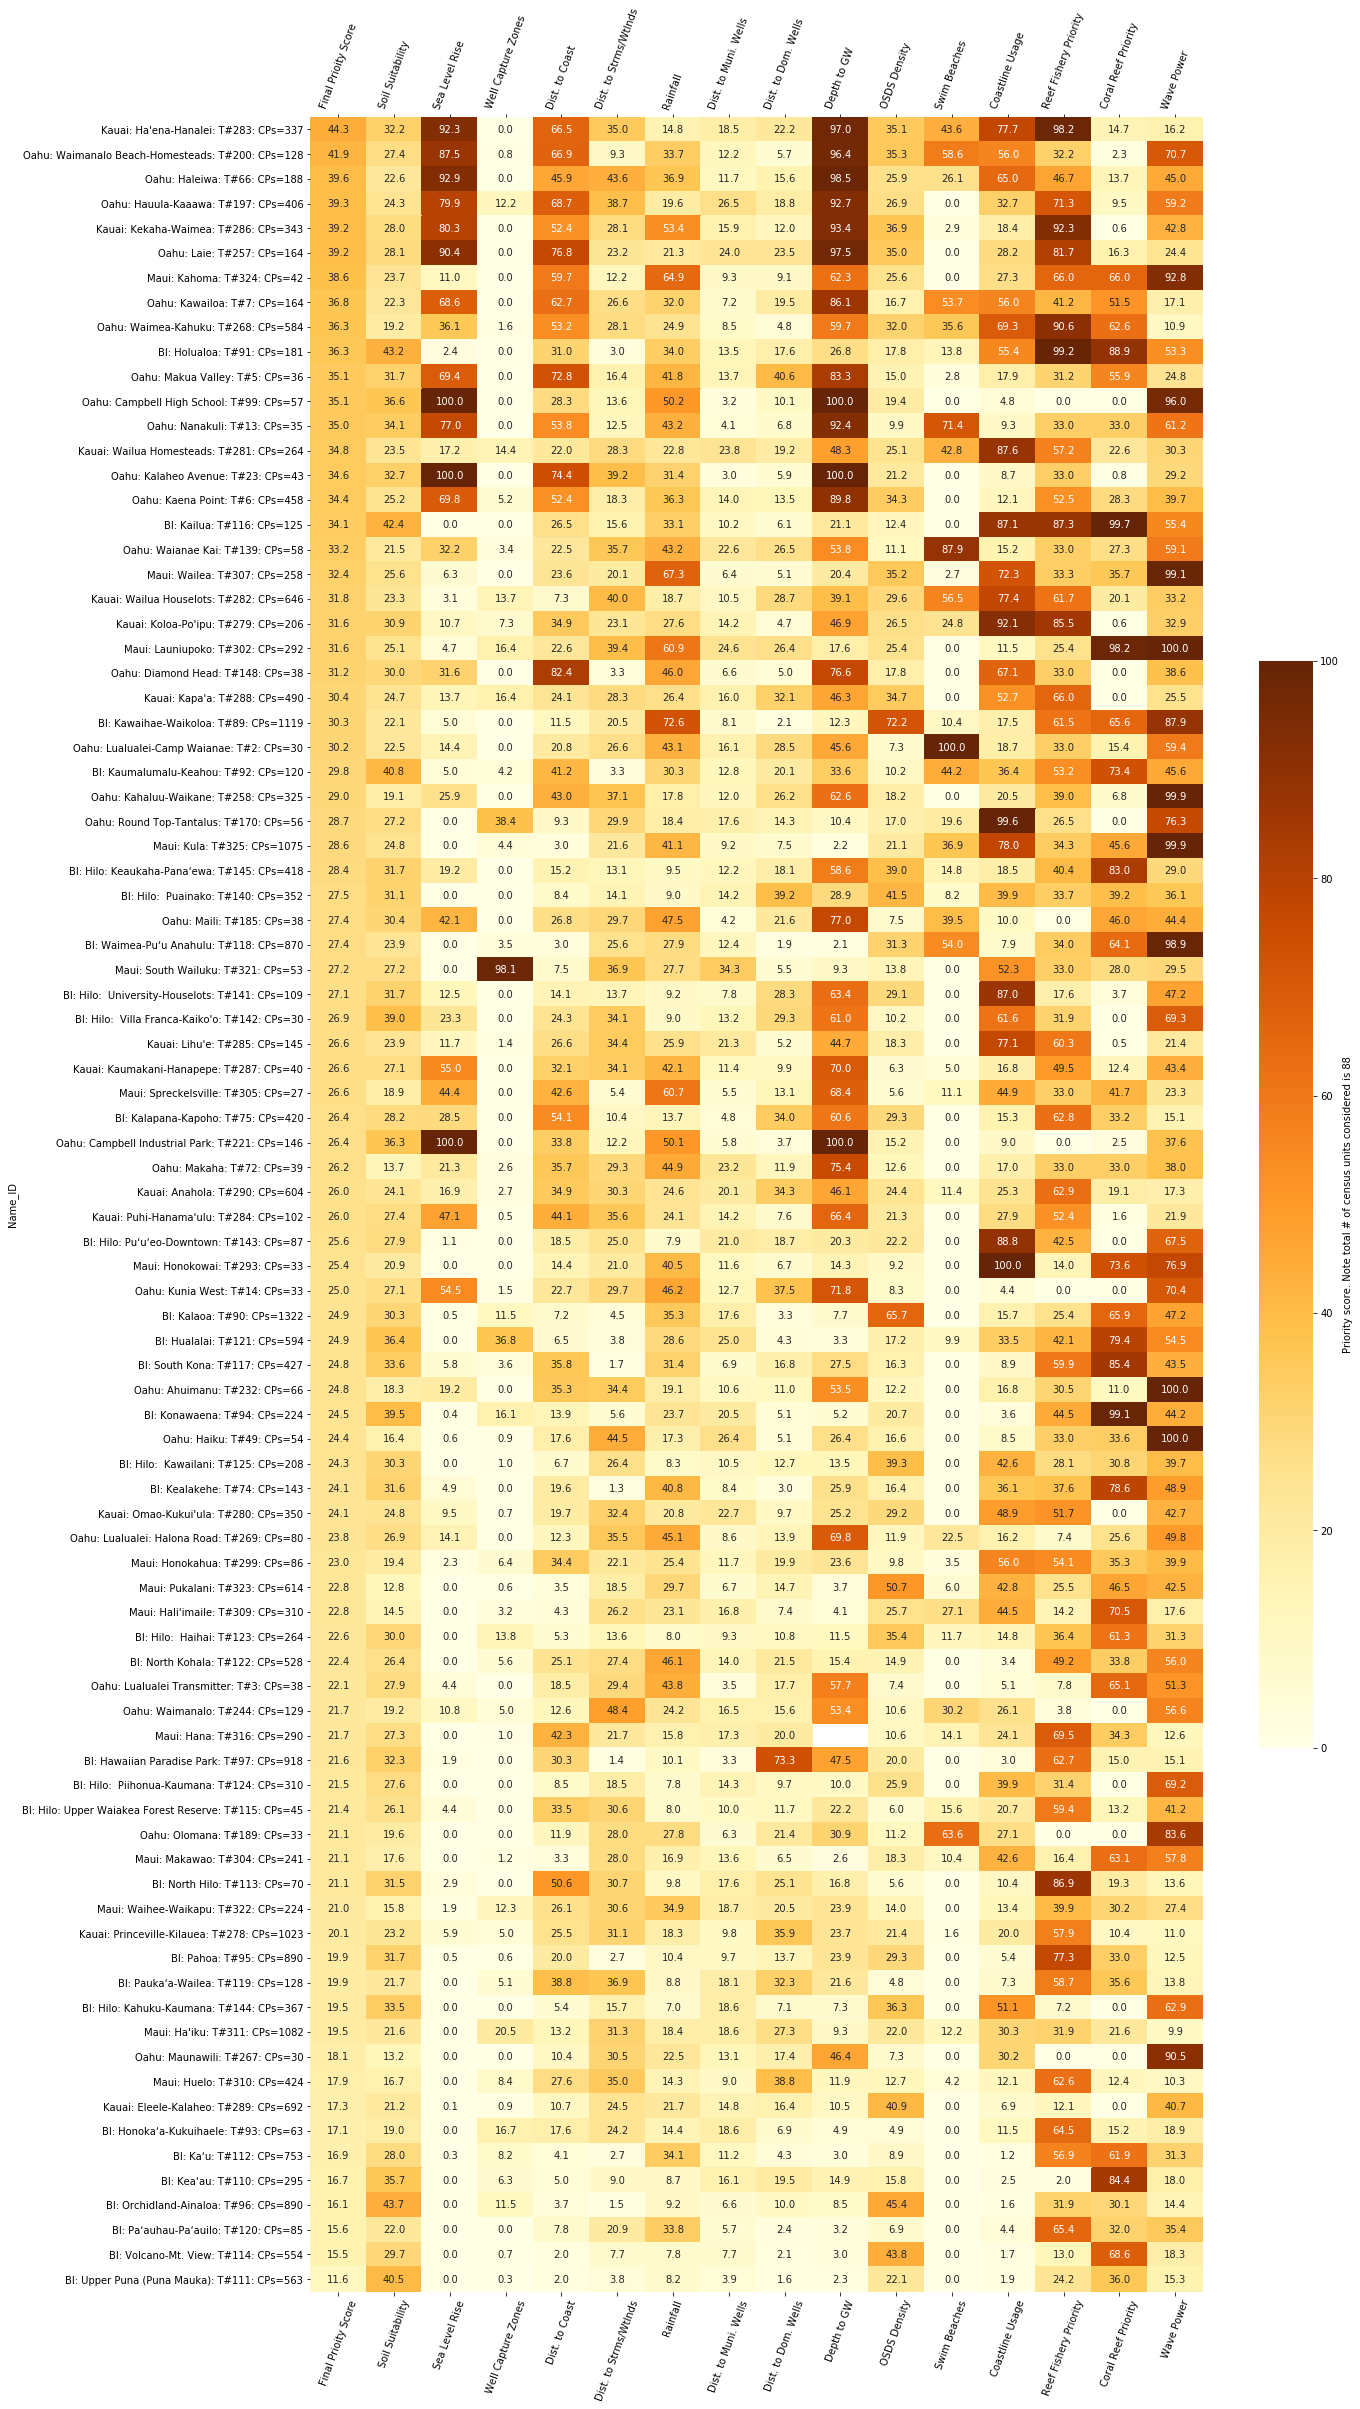

In [87]:
# Plot out comparison heatmap 

Total_census_tracts = 103

fig, ax = plt.subplots(figsize=(20, 40))
total_num = len(compare_priority_score_Track)
#plt.title("Ranks for all {} census Tracks".format(total_num), fontsize=18, y=1.05)
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = True, bottom=True, top = True, labeltop=True)
plt.xticks(rotation=70)
bar_label = "Priority score. Note total # of census units considered is {}".format(len(Tracks_priority_frame_base['OSDS_count']))
g= sns.heatmap(compare_priority_score_Track, annot=True,  cmap = 'YlOrBr', fmt=".1f", cbar_kws={'label': bar_label, "shrink": 0.5})
plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.png"), bbox_inches='tight')

print_info_for_islands("Statewide", Tracks_priority_frame_base, Total_census_tracts)

### Plot out island by island tables and info

In [88]:
%run functions.py

The island of Oahu contains 3456 cesspools and has a total of 242 census tracts although only 27 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 44% or 12 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 26% or 7 of them were categorized as medium (2) priority and 30% or 8 of them were categorized as low (3) priority. The total number of cesspools on Oahu catergorized as high (1) priority was 2321, with 672 and 463 as medium (2) and low (3) priority, respectivly.


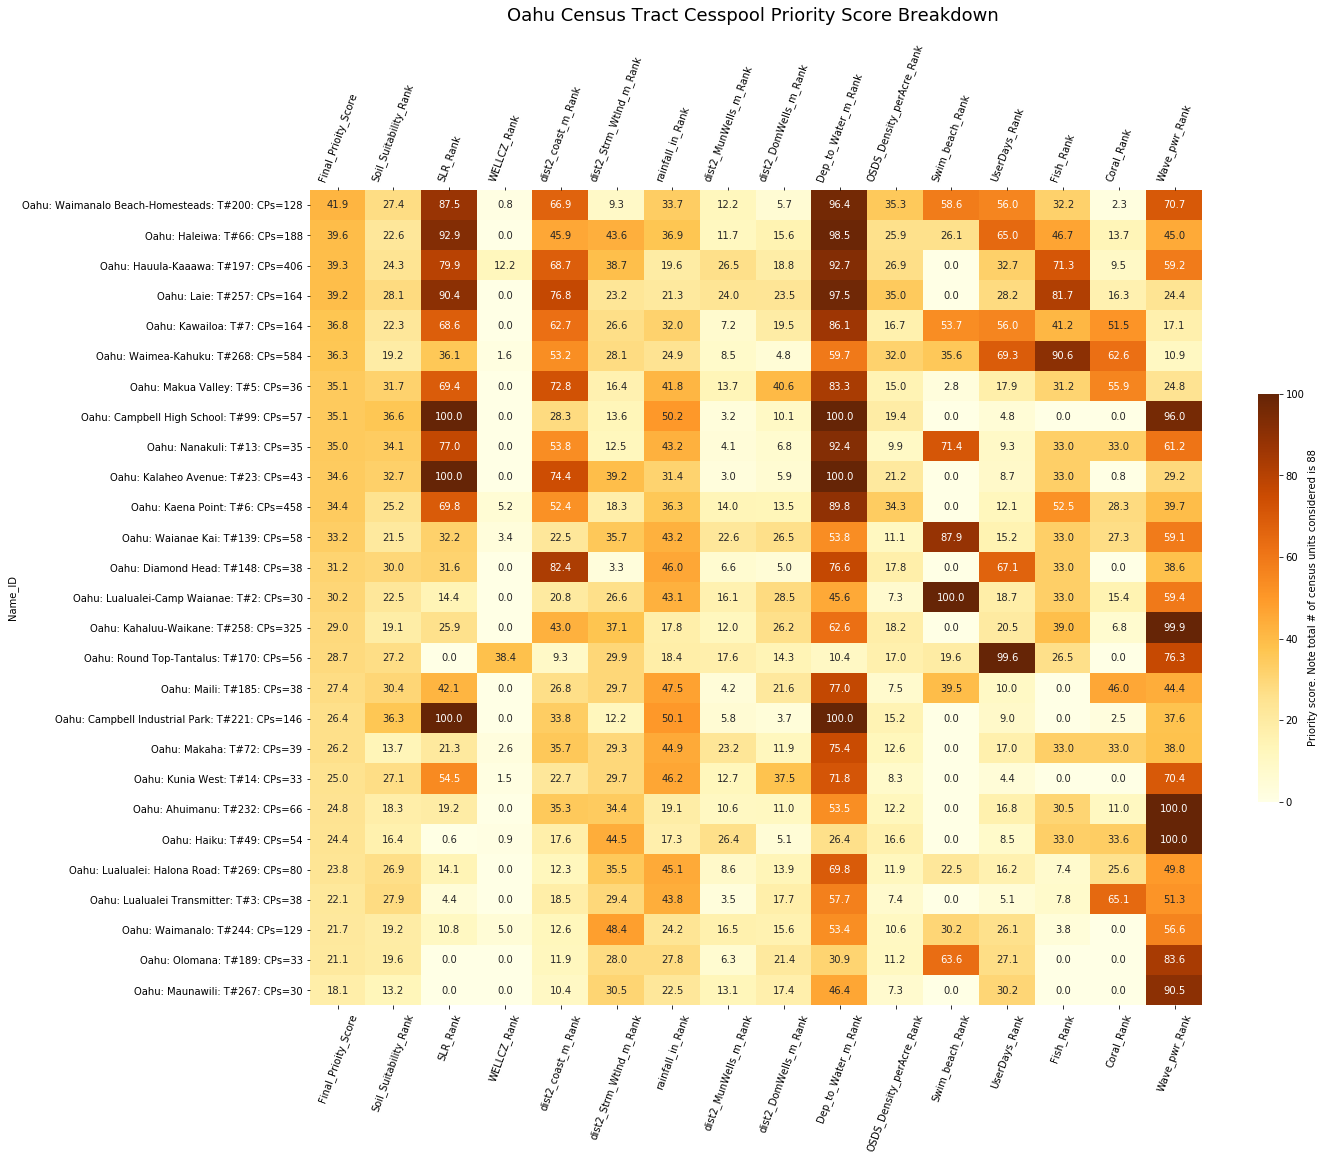

In [89]:
# Plot out comparison heatmap 

Isla = "Oahu"
Total_census_tracts = 242   # Oahu 242, Maui 31, BI 33, Kauai 13
Width = 20
Height = 15
Title = "Oahu Census Tract Cesspool Priority Score Breakdown "

Oahu_compare_priority_score_Track = Plot_island_comparison_heatmap(Tracks_priority_frame_base, WantCols, Track_meta, 
                                                                       Isla, Width, Height, Title)
Oahu_table_track = Make_table_Track(Tracks_priority_frame_base, Isla)
Oahu_table_track.to_csv(os.path.join("./Outputs/Census_aggregared_CSVs", "Island_{}_Track_report_table.csv".format(Isla)))

# Print out some text for results section
print_info_for_islands(Isla, Oahu_table_track, Total_census_tracts)

The island of BI contains 13472 cesspools and has a total of 33 census tracts although only 33 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 6% or 2 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 24% or 8 of them were categorized as medium (2) priority and 70% or 23 of them were categorized as low (3) priority. The total number of cesspools on BI catergorized as high (1) priority was 306, with 3438 and 9728 as medium (2) and low (3) priority, respectivly.


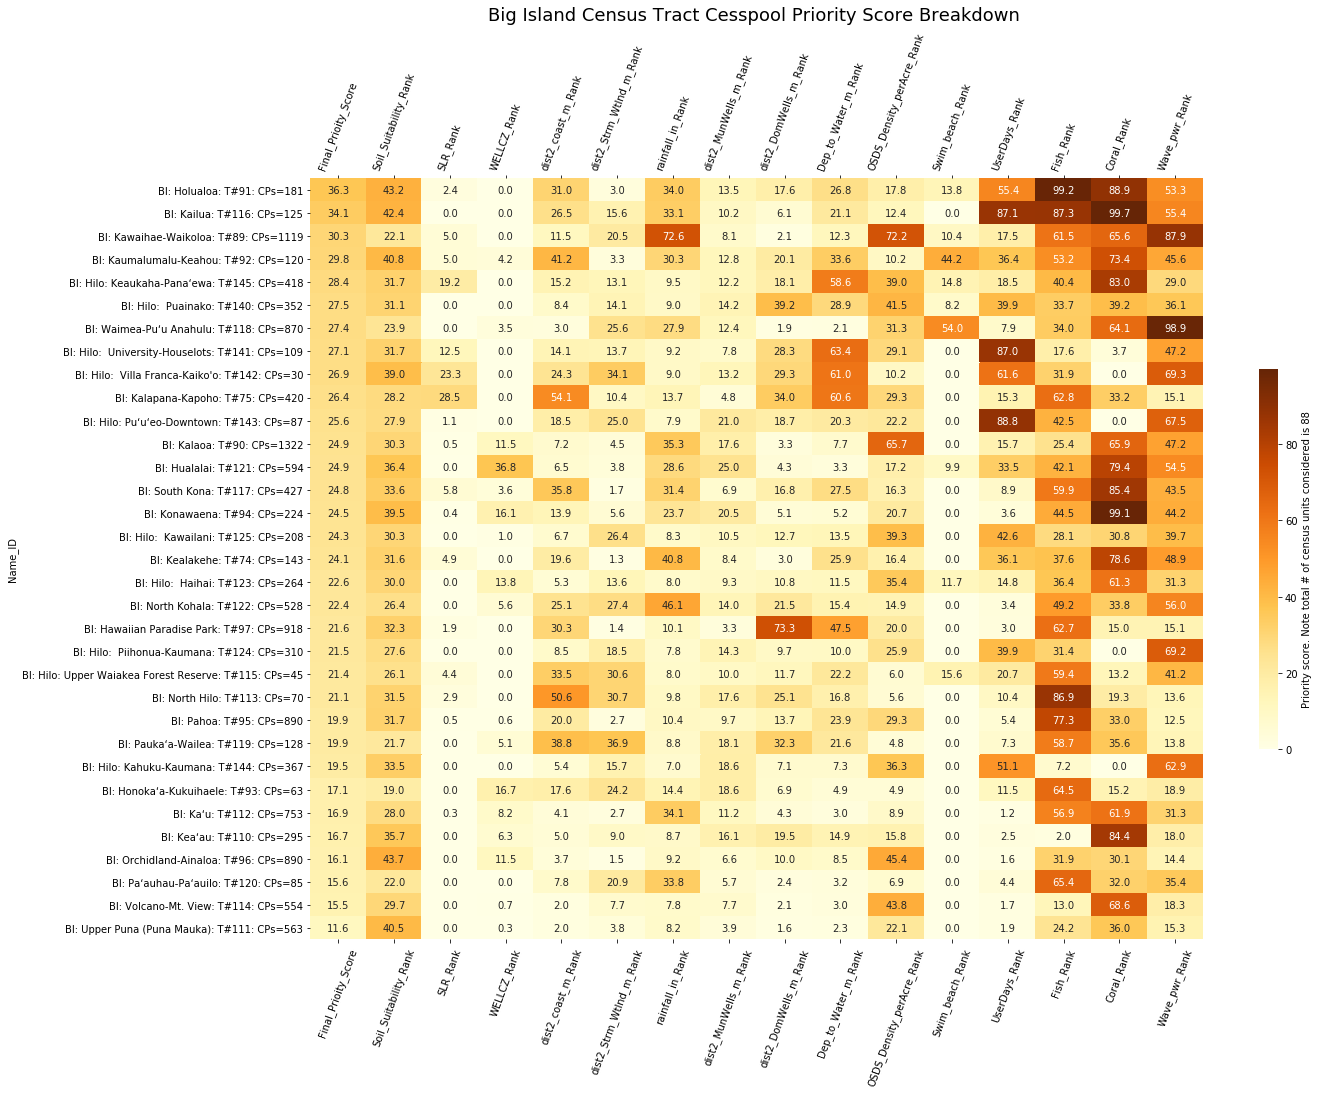

In [90]:
# Plot out comparison heatmap 

Isla = "BI"
Total_census_tracts = 33   # Oahu 242, Maui 31, BI 33, Kauai 13
Width = 20
Height = 14
Title = "Big Island Census Tract Cesspool Priority Score Breakdown "

BI_compare_priority_score_Track = Plot_island_comparison_heatmap(Tracks_priority_frame_base, WantCols, Track_meta, 
                               Isla, Width, Height, Title)

BI_table_track = Make_table_Track(Tracks_priority_frame_base, Isla)
BI_table_track.to_csv(os.path.join("./Outputs/Census_aggregared_CSVs", "Island_{}_Track_report_table.csv".format(Isla)))

# Print out some text for results section
print_info_for_islands(Isla, BI_table_track, Total_census_tracts)

The island of Maui contains 5051 cesspools and has a total of 31 census tracts although only 15 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 20% or 3 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 20% or 3 of them were categorized as medium (2) priority and 60% or 9 of them were categorized as low (3) priority. The total number of cesspools on Maui catergorized as high (1) priority was 592, with 1155 and 3304 as medium (2) and low (3) priority, respectivly.


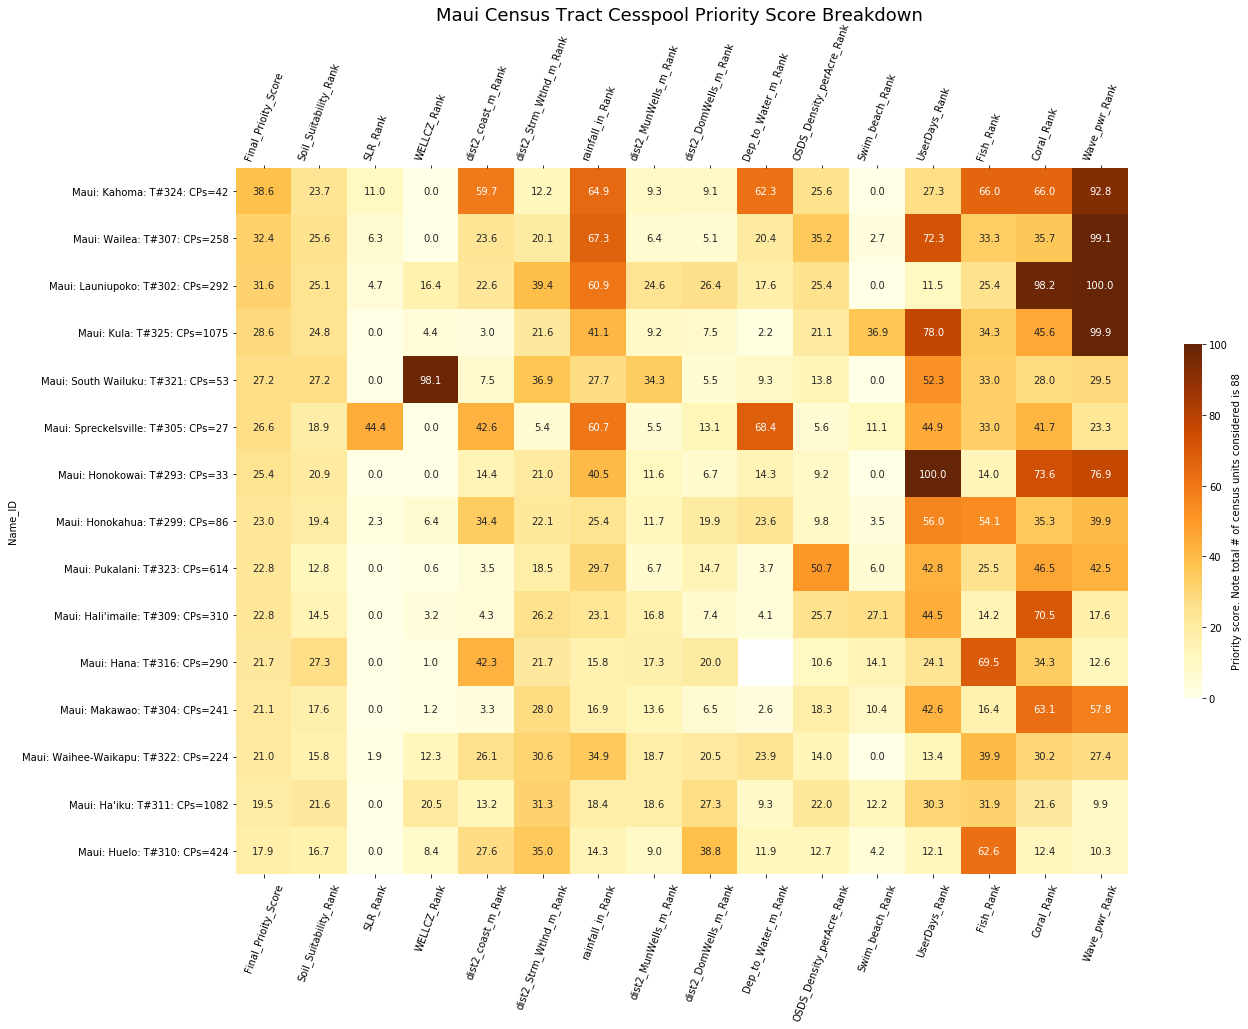

In [91]:
# Plot out comparison heatmap 

Isla = "Maui"
Total_census_tracts = 31   # Oahu 242, Maui 31, BI 33, Kauai 13
Width = 20
Height = 13
Title = "Maui Census Tract Cesspool Priority Score Breakdown "

Maui_compare_priority_score_Track = Plot_island_comparison_heatmap(Tracks_priority_frame_base, WantCols, Track_meta, 
                               Isla, Width, Height, Title)

Maui_table_track = Make_table_Track(Tracks_priority_frame_base, Isla)
Maui_table_track.to_csv(os.path.join("./Outputs/Census_aggregared_CSVs", "Island_{}_Track_report_table.csv".format(Isla)))

# Print out some text for results section
print_info_for_islands(Isla, Maui_table_track, Total_census_tracts)

The island of Kauai contains 5242 cesspools and has a total of 13 census tracts although only 13 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 38% or 5 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 31% or 4 of them were categorized as medium (2) priority and 31% or 4 of them were categorized as low (3) priority. The total number of cesspools on Kauai catergorized as high (1) priority was 1796, with 1279 and 2167 as medium (2) and low (3) priority, respectivly.


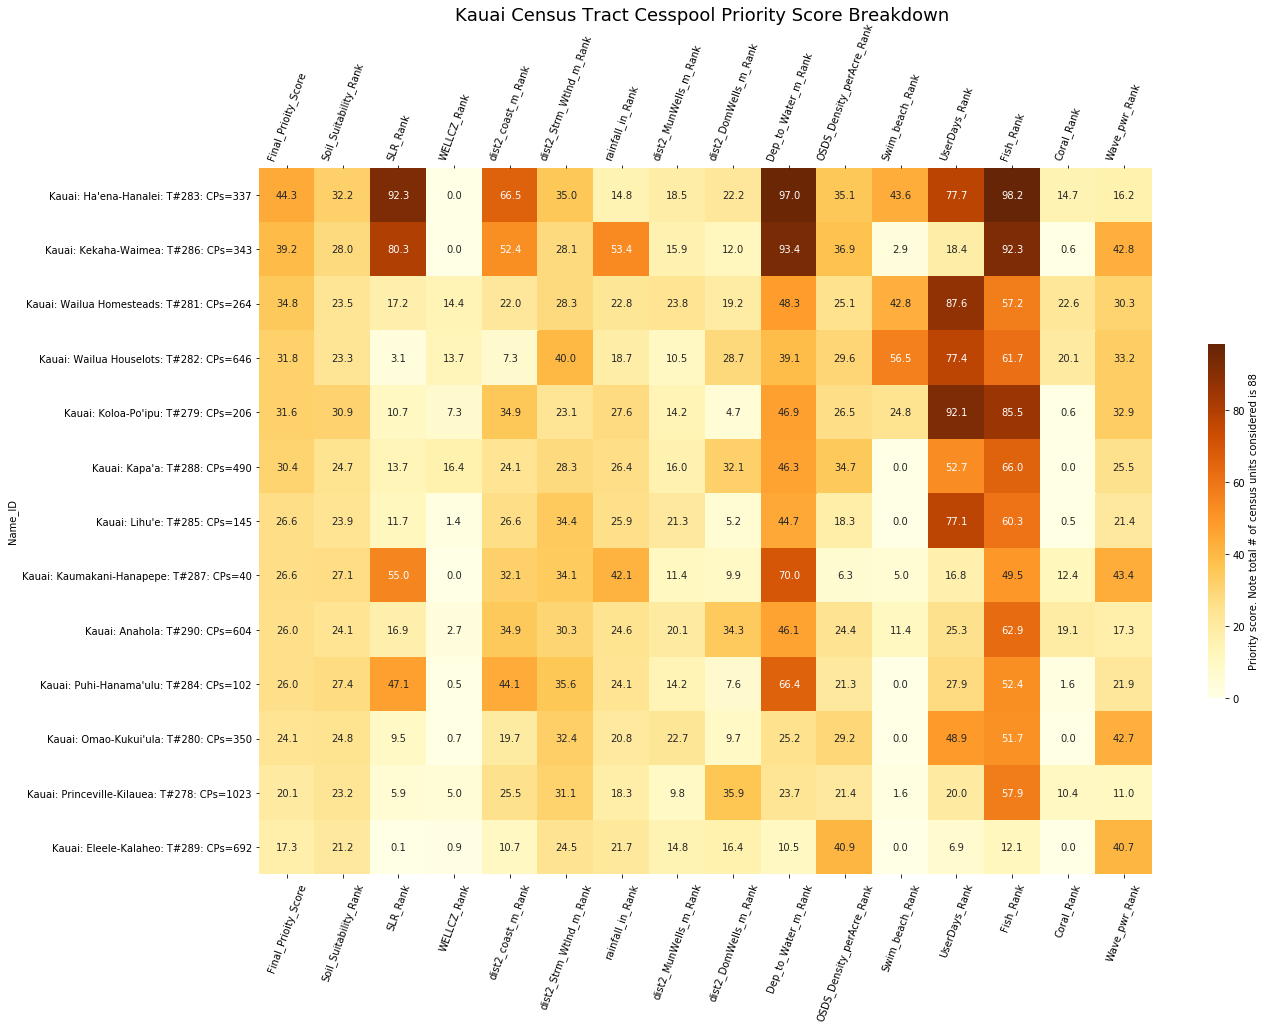

In [92]:
# Plot out comparison heatmap 

Isla = "Kauai"
Total_census_tracts = 13   # Oahu 242, Maui 31, BI 33, Kauai 13
Width = 20
Height = 13
Title = "Kauai Census Tract Cesspool Priority Score Breakdown "

Kauai_compare_priority_score_Track = Plot_island_comparison_heatmap(Tracks_priority_frame_base, WantCols, Track_meta, 
                               Isla, Width, Height, Title)

Kauai_table_track = Make_table_Track(Tracks_priority_frame_base, Isla)
Kauai_table_track.to_csv(os.path.join("./Outputs/Census_aggregared_CSVs", "Island_{}_Track_report_table.csv".format(Isla)))

# Print out some text for results section
print_info_for_islands(Isla, Kauai_table_track, Total_census_tracts)

#### Quick calculation of how many cesspools are in each catergory 

In [93]:
OSDS_Sum_Piv = pd.pivot_table(Tracks_priority_frame_base, index='Final_Cat_Ranking', aggfunc = 'sum')
OSDS_Sum_Piv['OSDS_pct_in_rank'] = OSDS_Sum_Piv['OSDS_count']/len(OSDS)*100
OSDS_Sum_Piv[['OSDS_count', 'OSDS_pct_in_rank']]
# 62% in Low,  21% in Med, 16% in High

,OSDS_count,OSDS_pct_in_rank
Final_Cat_Ranking,,
High,5015,17.947250
Low,15662,56.049816
Medium,6544,23.419103


## Save Census Area Shapefiles
!! SUPER LONG RUNTIMES ON CELLS BELOW !!

### Print Shapefile, summarized by census Tracts 

In [94]:
# For tracks 
UnitCol=['Track_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   #  

# Group up the OSDS units into census areas 
Tracks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=25)
Tracks_priority_frame =   Tracks_priority_frame.merge(Track_meta, on='Track_ID', how='left')  # Add in the name ID from the Track_meta in above cell
Tracks_priority_frame['Name_ID'] = Tracks_priority_frame['Name_ID']+": CPs="+Tracks_priority_frame['OSDS_count'].astype(str)
Tracks_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Tracks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Full.shp')  
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Full.csv'))

# Save clean Shapefile 
Pivot_df = Tracks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Clean.shp')  
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Clean.csv'))

### Print Shapefile, summarized by census Block_Groups 

In [95]:
UnitCol=['BlockGp_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   # 

Block_groups_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=20)
# get the name metadata from other metadata files
Block_groups_meta = get_blkGrp_names(os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Block_Groups_Meta_w2017.shp'), 'BlockGp_ID')
Block_groups_priority_frame =   Block_groups_priority_frame.merge(Block_groups_meta, on=UnitCol, how='left')  # Add in the name ID from the Track_meta in above cell
Block_groups_priority_frame['Name_ID'] = Block_groups_priority_frame['Name_ID']+": CPs="+Block_groups_priority_frame['OSDS_count'].astype(str)
Block_groups_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Block_groups_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Full.csv'))

# Save clean Shapefile 
Pivot_df = Block_groups_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Clean.csv'))

### Print Shapefile, summarized by census Blocks

In [96]:
UnitCol=['BlockBk_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   # 

Blocks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=10)

# Save full shapefile 
Pivot_df = Blocks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Full.csv'))

# Save clean Shapefile 
Pivot_df = Blocks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Clean.csv'))

### Print final priority OSDS master 

In [97]:
# Save the final priority CP dots
BASE_PRIORITY_MASTER.to_csv(os.path.join(".", "Outputs/OSDS_Dots", "Final_Priority_Master_SEPTICS.csv"))

# Convert CSV to a POINTS shapefile of the OSDS points 
XFieldName = 'X'                                 # THe x field longitude 
YFieldName = 'Y'                                 # THe y field latitude 
spatialRef = arcpy.SpatialReference(4326)        # THis is wgs84
csvFilePath = os.path.join(".", "Outputs/OSDS_Dots", "Final_Priority_Master_SEPTICS.csv")    # Path to input csv with lat and lon as columns X and Y
shpFilePath = os.path.join(".", "Outputs/OSDS_Dots")

arcpy.MakeXYEventLayer_management(csvFilePath, XFieldName, YFieldName, 'Final_Priority_Master_SEPTICS', spatial_reference=spatialRef)
arcpy.FeatureClassToShapefile_conversion('Final_Priority_Master_SEPTICS', shpFilePath)    # Shapefile name will be "{}.shp".format(var)

# And print the raw riskfactors as a shapefile too
csvFilePath = os.path.join(".", "Outputs/OSDS_Dots", 'SEPTICS_MASTER_RiskFactors_v1.csv')  # Path to input csv with lat and lon as columns X and Y
shpFilePath = os.path.join(".", "Outputs/OSDS_Dots")
arcpy.MakeXYEventLayer_management(csvFilePath, XFieldName, YFieldName, 'SEPTICS_MASTER_RiskFactors_v1', spatial_reference=spatialRef)
arcpy.FeatureClassToShapefile_conversion('SEPTICS_MASTER_RiskFactors_v1', shpFilePath)    # Shapefile name will be "{}.shp".format(var)



<Result '.\\Outputs\\OSDS_Dots'>

### Print out OSDS dots shapefiles with census areas attributes 

In [98]:
# create OSDS dots file with the synthesized TRACT area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_Tracts_Clean_atts.shp"))


# create OSDS dots file with the synthesized BLOCKGroups area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_BlkGrps_Clean_atts.shp"))

# create OSDS dots file with the synthesized BLOCKGroups area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_Blocks_Clean_atts.shp"))

<Result '.\\Outputs\\OSDS_Dots\\OSDS_dots_w_Blocks_Clean_atts.shp'>

## QAQC on each dataset

In [99]:
for i in mergeframes_list:
    print("{}".format(i.columns[-1]))
    print("Number of points                   = {}".format(len(i)))
    print("Number of Uid that are null        = {}".format(len(i[i["Uid"].isnull()])))
    print("Number of Uid that are zero        = {}".format(len(i[i["Uid"] == 0])))
    print("Number of {} values that are null  = {}".format(i.columns[-1], len(i[i[i.columns[-1]].isnull()])))
    print("Number of {} values that are zero  = {}".format(i.columns[-1], len(i[i[i.columns[-1]] == 0])))
    print('\n')        

BlockBk_ID
Number of points                   = 27943
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of BlockBk_ID values that are null  = 0
Number of BlockBk_ID values that are zero  = 378


BlockGp_ID
Number of points                   = 27943
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of BlockGp_ID values that are null  = 0
Number of BlockGp_ID values that are zero  = 378


Track_ID
Number of points                   = 27943
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of Track_ID values that are null  = 0
Number of Track_ID values that are zero  = 378


Flikr_Y
Number of points                   = 27943
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of Flikr_Y values that are null  = 0
Number of Flikr_Y values that are zero  = 4436


UserDays
Number of points                   = 27943
Number of Uid that are null        = 0
Num